In [164]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso, Ridge
from sklearn.linear_model import RidgeCV, LassoCV

import statsmodels.api as sm

from pandas.api.types import is_numeric_dtype

import eli5
from eli5.sklearn import PermutationImportance
from eli5.permutation_importance import get_score_importances
from sklearn.feature_selection import SelectFromModel

# pandas tricks for better display
pd.options.display.max_columns = 50  
pd.options.display.max_rows = 500     
pd.options.display.max_colwidth = 100
pd.options.display.precision = 3

%matplotlib inline

In [153]:
data = pd.read_csv("performance_year_financial_and_quality_results_puf_2020_01_01.csv")

In [238]:
text_size = 12
fig_scale = 3

# Background

In 2019, the United States collectively spent \\$ 3.8 trillion on healthcare - more than \$11,000 per person. This is nearly 15% higher than it was at the start of decade, with no obvious signs of slowing; at current rates, our healthcare costs are expected to rise to almost \\$7 trillion by 2028. Much of these costs get passed on to consumers in the form of higher premiums, higher deductibles, and higher contributions to support dwindling Medicare funds. Needless to say, the state of our healthcare industry is very grim, and we need to take drastic cost containment actions over the coming decade to slow or reverse the trend we're seeing. (source: https://www.investopedia.com/insurance/why-do-healthcare-costs-keep-rising/)

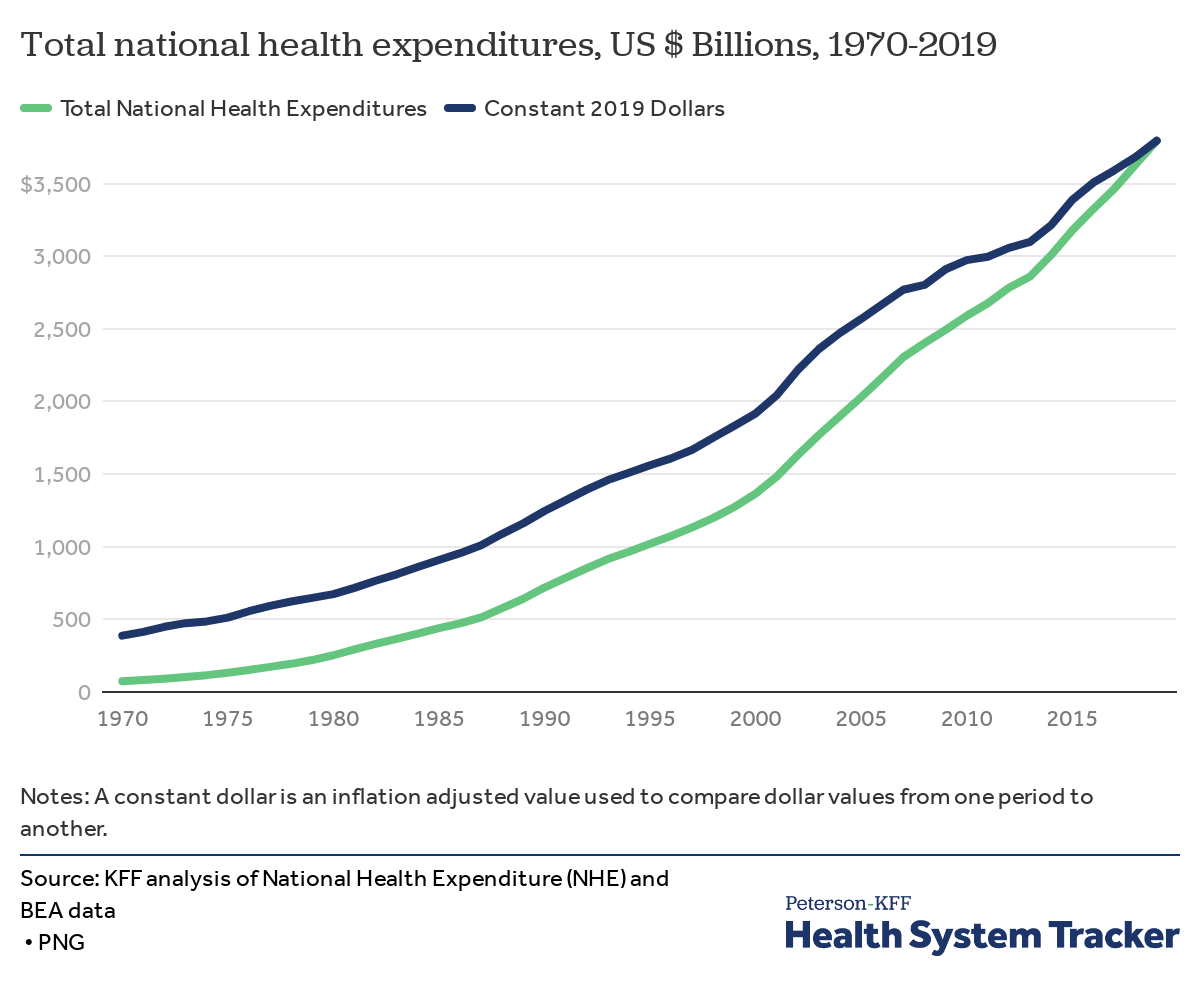

The biggest drivers of our healthcare spending are hospital care (31\% of overall spend) and physician services (20\% of overall spend) - broadly, these two collectively encompass care that Americans receive from physician organizations. The vast majority of these providers are paid in a Fee-For-Service (FFS) fashion, wherein they are paid by insurers for completing services (for instance, conducting an annual physical, doing an MRI, completing a surgery, etc.). Put otherwise, physicians complete services, submit bills to insuerers, and insurers reimburse them per negotiated rates. As one can imagine, this can create a perverse incentive where physicians are reimbursed more for doing more, thereby creating a system that heavily rewards "overtreatment" and does not motivate accountability for good outcomes. There has been much dialogue about a new payment paradigm named "Value-Based Care", wherein physicians assume different levels of risk for managing patient populations and face financial penalities for poor outcomes (for instance, if a patient is admitted to the emergency room for an avoidable reason, the physician group responsible for that patient's care is financially penalized). Our aim is to evaluate results from one such program - the Medicare Shared Savings Program (MSSP).  

Medicare is a public insurance in the United States that primarily covers individuals 65 years and older, but also covers people with certain disabilities (chiefly, End-Stage-Renal-Disease, i.e. kidney failure). The Medicare Shared Savings Program traces its roots to the George W. Bush administration, but was formally entrenched following the passage of the Affordable Care Act (ACA) in 2012. It is designed to promote a value-based-care arrangement called an Accountable Care Organization (ACO), in which groups of doctors, hospitals, and other health care providers, who come together voluntarily to give coordinated high-quality care to their Medicare patients. The details of the program are extremely complicated (outlined here: https://www.cms.gov/Medicare/Medicare-Fee-for-Service-Payment/sharedsavingsprogram/Downloads/Shared-Savings-Losses-Assignment-Spec-V6.pdf). On a high level, if a physician group decides to partake in MSSP, CMS (the insitution that administers Medicare) computes the expected costs for the patients under the ACO's care, and then reimburses the physician group based on how much they save relative to that expected cost (also known as the "benchmark"). There are different risk tracks (outlined below), which enable providers to assume different levels of upside and downside risk. Generally, the more downside potential the ACO is willing to assume (i.e. in the case that they exceed expected costs, they will have to pay Medicare a portion of those losses), the more upside potential they have (source: https://www.cms.gov/Medicare/Medicare-Fee-for-Service-Payment/sharedsavingsprogram/Downloads/ssp-aco-participation-options.pdf). 

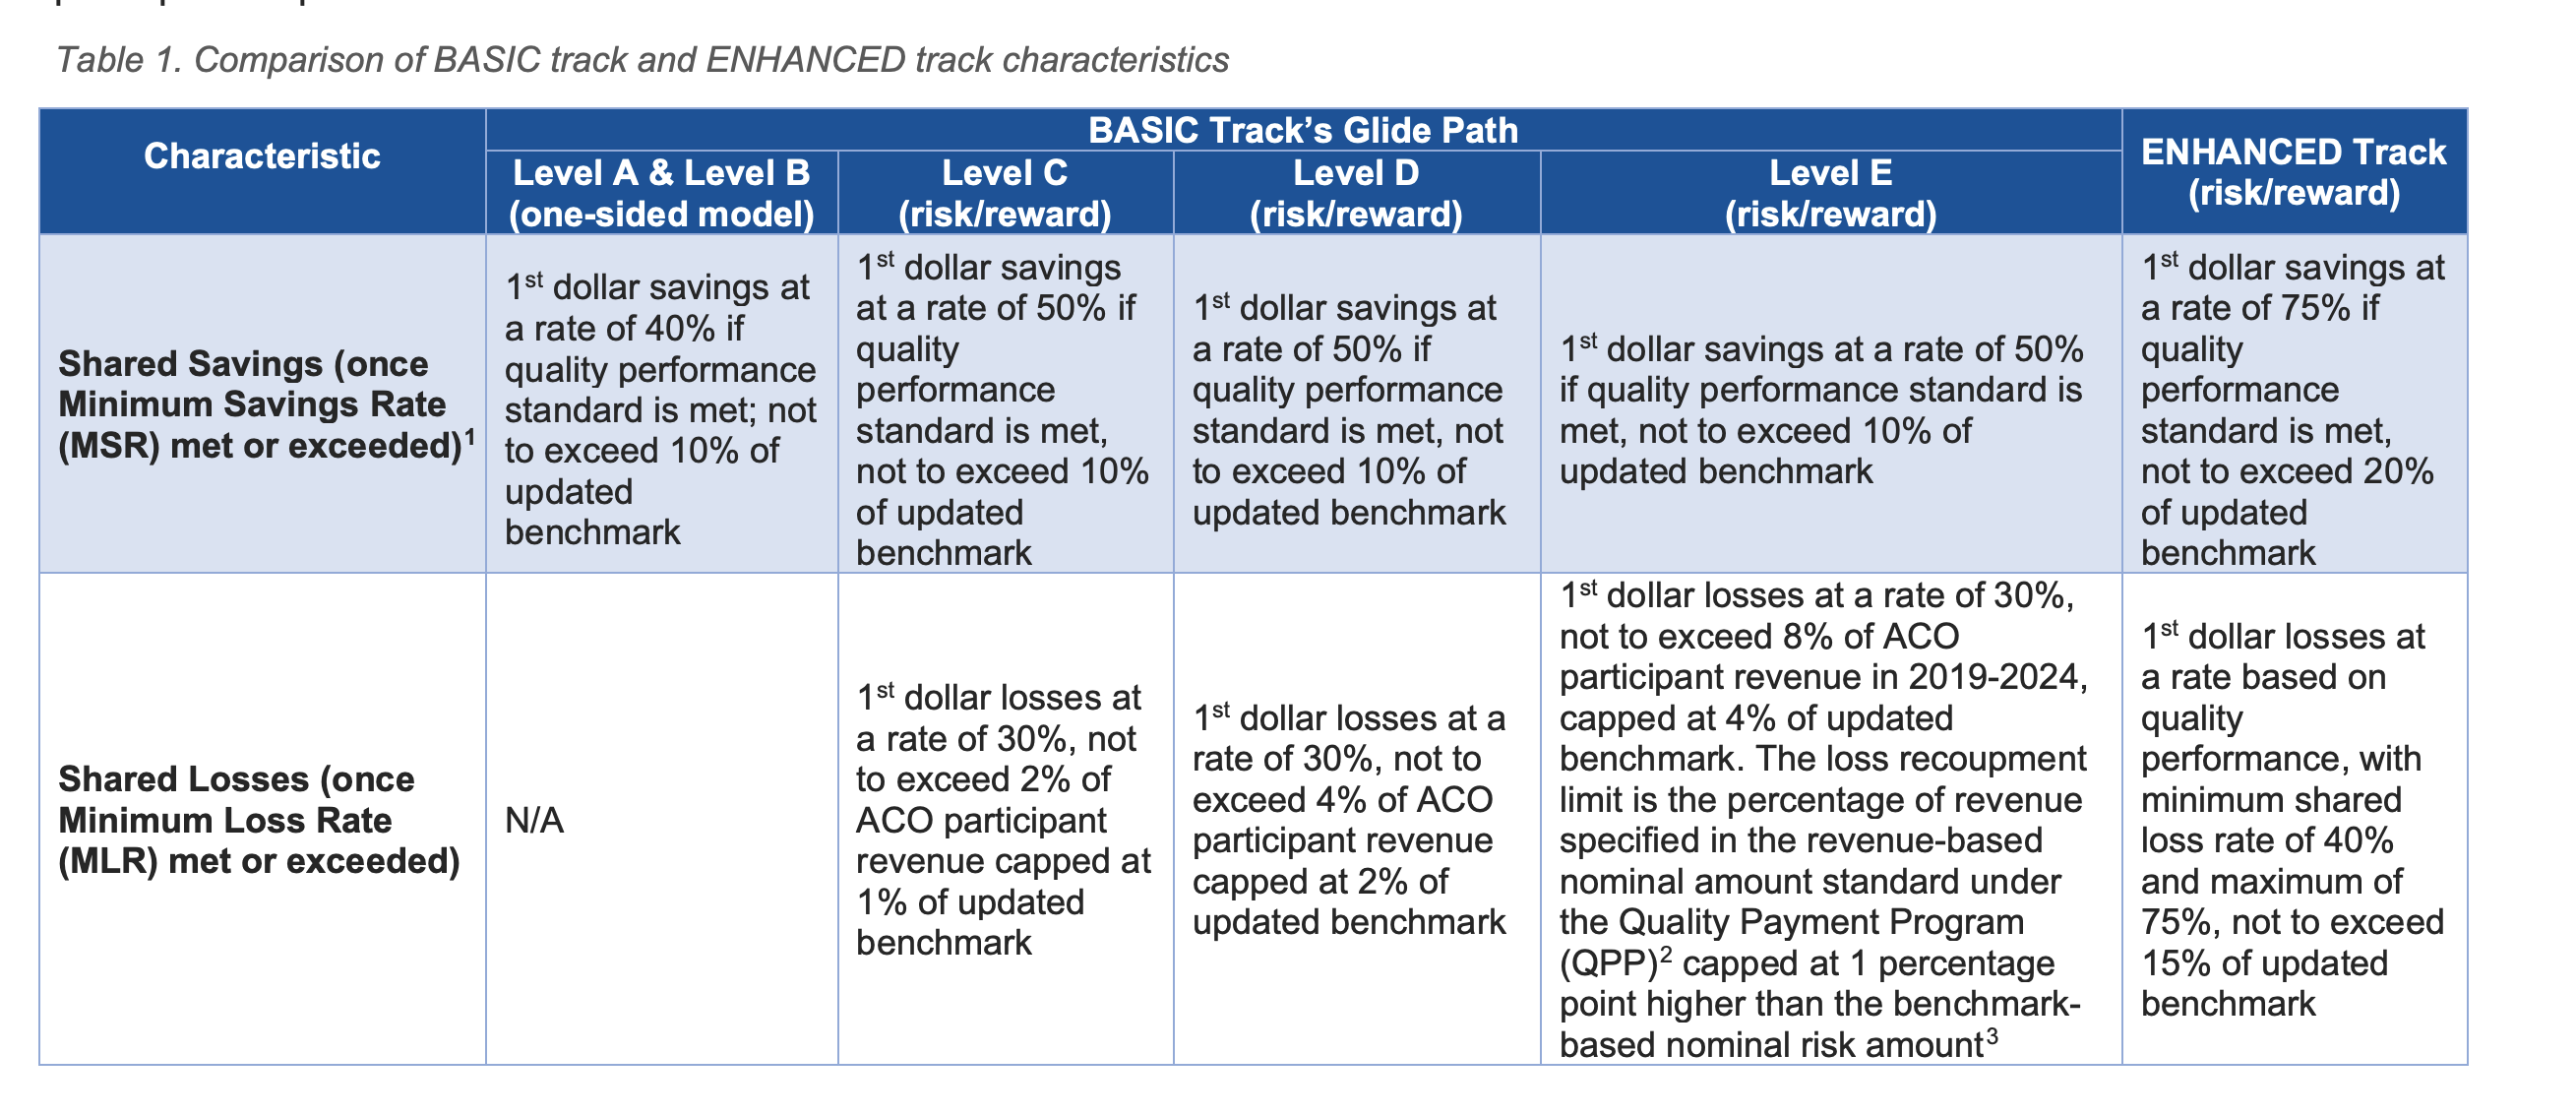

Our goal in this project is to use publicly available MSSP data to predict drivers of savings in the MSSP program. The MSSP public use file contains over 200 characteristics on each ACO that participates in the program, and our primarily outcome variable will be the gross margin saving percentage that the ACO produced in the January 2020-December 2020 period (Total Benchmark Expenditures Minus Assigned Beneficiary Expenditures as a percent of Total Benchmark Expenditures). 

# EDA

There are 162 predictors in total. The total predictors can be divided into 12 groups:\
1, Basic information for the ACOs, 12 in total:
- 'ACO_ID'
- 'ACO_Name'
- 'ACO_State'
- 'Agree_Type'
- 'Agreement_Period_Num'
- 'Initial_Start_Date'
- 'Current_Start_Date'
- 'N_AB'
- What saving models have the ACOs participated:
    - 'Risk_Model'
    - 'Adv_Pay'
    - 'AIM'
    - 'SNF_Waiver'
    
2, Saving related (these are very likely to be our responses)， 5 in total:
- 'Sav_rate'
- 'MinSavPerc'
- 'BnchmkMinExp'
- 'GenSaveLoss'
- 'EarnSaveLoss'

3, Which track and BASIC Level do the ACOs selected, 10 in total:
- 'Current_Track_1'
- 'Current_Track_2'
- 'Current_Track_3'
- 'Current_Track_1_Plus'
- 'Current_BASIC_A'
- 'Current_BASIC_B'
- 'Current_BASIC_C'
- 'Current_BASIC_D'
- 'Current_BASIC_E'
- 'Current_ENHANCED'

4, Per capita ESRD/DISABLED/AGED(DUAL)/AGED(NON-DUAL) expenditures in benchmark year 1,2,3 and performance year, 17 in total:
- 'Per_Capita_Exp_ALL_ESRD_BY1'
- 'Per_Capita_Exp_ALL_DIS_BY1'
- 'Per_Capita_Exp_ALL_AGDU_BY1'
- 'Per_Capita_Exp_ALL_AGND_BY1'
- 'Per_Capita_Exp_ALL_ESRD_BY2'
- 'Per_Capita_Exp_ALL_DIS_BY2'
- 'Per_Capita_Exp_ALL_AGDU_BY2'
- 'Per_Capita_Exp_ALL_AGND_BY2'
- 'Per_Capita_Exp_ALL_ESRD_BY3'
- 'Per_Capita_Exp_ALL_DIS_BY3'
- 'Per_Capita_Exp_ALL_AGDU_BY3'
- 'Per_Capita_Exp_ALL_AGND_BY3'
- 'Per_Capita_Exp_ALL_ESRD_PY'
- 'Per_Capita_Exp_ALL_DIS_PY'
- 'Per_Capita_Exp_ALL_AGDU_PY'
- 'Per_Capita_Exp_ALL_AGND_PY'
- 'Per_Capita_Exp_TOTAL_PY'

5, Final, mean prospective CMS-HCC risk score for ESRD HCC/DISABLED/AGED(DUAL HCC)/AGED(NON-DUAL HCC) enrollment type in benchmark year 1, 2 ,3 and performance year, 16 in total:
- 'CMS_HCC_RiskScore_ESRD_BY1'
- 'CMS_HCC_RiskScore_DIS_BY1'
- 'CMS_HCC_RiskScore_AGDU_BY1'
- 'CMS_HCC_RiskScore_AGND_BY1'
- 'CMS_HCC_RiskScore_ESRD_BY2'
- 'CMS_HCC_RiskScore_DIS_BY2'
- 'CMS_HCC_RiskScore_AGDU_BY2'
- 'CMS_HCC_RiskScore_AGND_BY2'
- 'CMS_HCC_RiskScore_ESRD_BY3'
- 'CMS_HCC_RiskScore_DIS_BY3'
- 'CMS_HCC_RiskScore_AGDU_BY3'
- 'CMS_HCC_RiskScore_AGND_BY3'
- 'CMS_HCC_RiskScore_ESRD_PY'
- 'CMS_HCC_RiskScore_DIS_PY'
- 'CMS_HCC_RiskScore_AGDU_PY'
- 'CMS_HCC_RiskScore_AGND_PY'

6, Total number of assigned beneficiaries categorized by enrollment type, age, gender and race, 21 in total:
- 'N_AB_Year_ESRD_BY3'
- 'N_AB_Year_DIS_BY3'
- 'N_AB_Year_AGED_Dual_BY3'
- 'N_AB_Year_AGED_NonDual_BY3'
- 'N_AB_Year_PY'
- 'N_AB_Year_ESRD_PY'
- 'N_AB_Year_DIS_PY'
- 'N_AB_Year_AGED_Dual_PY'
- 'N_AB_Year_AGED_NonDual_PY'
- 'N_Ben_Age_0_64'
- 'N_Ben_Age_65_74'
- 'N_Ben_Age_75_84'
- 'N_Ben_Age_85plus'
- 'N_Ben_Female'
- 'N_Ben_Male'
- 'N_Ben_Race_White'
- 'N_Ben_Race_Black'
- 'N_Ben_Race_Asian'
- 'N_Ben_Race_Hisp'
- 'N_Ben_Race_Native'
- 'N_Ben_Race_Other'

7, Expenditures per assigned beneficiary person years categorized by different purposes, 12 in total:
- 'CapAnn_INP_All'
- 'CapAnn_INP_S_trm'
- 'CapAnn_INP_L_trm'
- 'CapAnn_INP_Rehab'
- 'CapAnn_INP_Psych'
- 'CapAnn_HSP'
- 'CapAnn_SNF'
- 'CapAnn_OPD'
- 'CapAnn_PB'
- 'CapAnn_AmbPay'
- 'CapAnn_HHA'
- 'CapAnn_DME'

8, Total number of discharges per 1000 person years categorized by different services, 9 in total:
- 'ADM'
- 'ADM_S_Trm'
- 'ADM_L_Trm'
- 'ADM_Rehab'
- 'ADM_Psych'
- 'chf_adm'
- 'copd_adm'
- 'P_SNF_ADM'
- 'prov_Rate_1000'

9, Total number of different types of services per 1000 person years in the performance year, 9 in total:
- 'P_EDV_Vis'
- 'P_EDV_Vis_HOSP'
- 'P_CT_VIS'
- 'P_MRI_VIS'
- 'P_EM_Total'
- 'P_EM_PCP_Vis'
- 'P_EM_SP_Vis'
- 'P_Nurse_Vis'
- 'P_FQHC_RHC_Vis'
 
10, Total number of different types of medical groups or individuals participating in the ACO in the performance year, 11 in total:
- 'N_CAH'
- 'N_FQHC'
- 'N_RHC'
- 'N_ETA'
- 'N_Hosp'
- 'N_Fac_Other'
- 'N_PCP'
- 'N_Spec'
- 'N_NP'
- 'N_PA'
- 'N_CNS'
 
11, Consumer Assessment of Healthcare Providers and Systems (CAHPS), 23 in total:
- 'ACO1' ~ 'ACO28'

12, Other predictors, 17 in total **(need to discuss whether it can be fitted to the category above)**:
- 'DisAdj'
- 'DisAffQual'
- 'Met_QPS'
- 'QualScore'
- 'RecvdMean'
- 'RegTrndUpdt'
- 'PosRegAdj'
- Benchmark expenditures:
    - 'UpdatedBnchmk'
    - 'HistBnchmk'
    - 'ABtotBnchmk'
    - 'ABtotExp'
- Advanced payment related:
    - 'Adv_Pay_Amt'
    - 'Adv_Pay_Recoup'
- Sharing related:
    - 'QualPerfShare'
    - 'FinalShareRate'
    - 'RevLossLimit'
    - 'Rev_Exp_Cat'

### Columns with missing data

In [3]:
data.isnull().sum().loc[data.isnull().sum() > 0]

DisAdj            512
PosRegAdj         101
Adv_Pay_Amt       488
Adv_Pay_Recoup    488
ACO17               1
ACO42               2
ACO40               5
dtype: int64

### Columns with greatest entropy

In [4]:
# source: https://stackoverflow.com/questions/49685591/how-to-find-the-entropy-of-each-column-of-data-set-by-python
def pandas_entropy(column, base=None):
  vc = pd.Series(column).value_counts(normalize=True, sort=False)
  base = np.exp(1) if base is None else base
  return -(vc * np.log(vc)/np.log(base)).sum()

In [5]:
quant_cols = data.select_dtypes(exclude=['object'])
entropies = [pandas_entropy(x) for w, x in quant_cols.iteritems()]
entropies_series = pd.Series(data=entropies, index=quant_cols.columns)
entropies_series.sort_values(ascending=False).head(20)

BnchmkMinExp                   6.240
ABtotExp                       6.240
ABtotBnchmk                    6.240
Per_Capita_Exp_ALL_ESRD_BY2    6.235
Per_Capita_Exp_ALL_ESRD_BY3    6.235
Per_Capita_Exp_ALL_ESRD_PY     6.232
N_AB_Year_AGED_NonDual_PY      6.232
N_AB_Year_AGED_NonDual_BY3     6.229
Per_Capita_Exp_ALL_ESRD_BY1    6.229
N_AB_Year_PY                   6.227
N_Ben_Race_White               6.227
N_AB                           6.227
Per_Capita_Exp_ALL_AGDU_BY3    6.216
N_Ben_Female                   6.213
N_Ben_Male                     6.213
Per_Capita_Exp_ALL_AGDU_PY     6.211
Per_Capita_Exp_ALL_AGDU_BY2    6.208
N_Ben_Age_65_74                6.205
N_Ben_Age_75_84                6.199
Per_Capita_Exp_TOTAL_PY        6.190
dtype: float64

### Do total expenditures change with time for each type of patients?

Text(0.5, 1.0, 'Aged/non-dual')

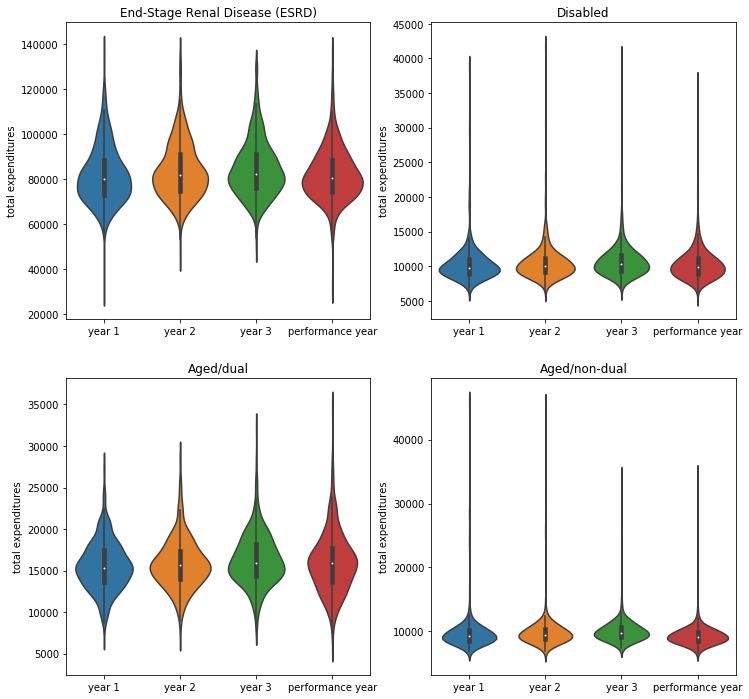

In [6]:
x_esrd = data[['Per_Capita_Exp_ALL_ESRD_BY1', 'Per_Capita_Exp_ALL_ESRD_BY2', 'Per_Capita_Exp_ALL_ESRD_BY3', 'Per_Capita_Exp_ALL_ESRD_PY']]
x_disabled = data[['Per_Capita_Exp_ALL_DIS_BY1', 'Per_Capita_Exp_ALL_DIS_BY2', 'Per_Capita_Exp_ALL_DIS_BY3', 'Per_Capita_Exp_ALL_DIS_PY']]
x_agdu = data[['Per_Capita_Exp_ALL_AGDU_BY1', 'Per_Capita_Exp_ALL_AGDU_BY2', 'Per_Capita_Exp_ALL_AGDU_BY3', 'Per_Capita_Exp_ALL_AGDU_PY']]
x_agnd = data[['Per_Capita_Exp_ALL_AGND_BY1', 'Per_Capita_Exp_ALL_AGND_BY2', 'Per_Capita_Exp_ALL_AGND_BY3', 'Per_Capita_Exp_ALL_AGND_PY']]

fig, ax = plt.subplots(2,2, figsize=(12,12))
sns.violinplot(data=x_esrd, ax=ax[0][0])
ax[0][0].set_xticklabels(['year 1', 'year 2', 'year 3', 'performance year'])
ax[0][0].set_ylabel('total expenditures')
ax[0][0].set_title('End-Stage Renal Disease (ESRD)')
sns.violinplot(data=x_disabled, ax=ax[0][1])
ax[0][1].set_xticklabels(['year 1', 'year 2', 'year 3', 'performance year'])
ax[0][1].set_ylabel('total expenditures')
ax[0][1].set_title('Disabled')
sns.violinplot(data=x_agdu, ax=ax[1][0])
ax[1][0].set_xticklabels(['year 1', 'year 2', 'year 3', 'performance year'])
ax[1][0].set_ylabel('total expenditures')
ax[1][0].set_title('Aged/dual')
sns.violinplot(data=x_agnd, ax=ax[1][1])
ax[1][1].set_xticklabels(['year 1', 'year 2', 'year 3', 'performance year'])
ax[1][1].set_ylabel('total expenditures')
ax[1][1].set_title('Aged/non-dual')

### Do different patient types result in different expenditures?

Text(0.5, 1.0, 'Comparison for different patient type in performance year')

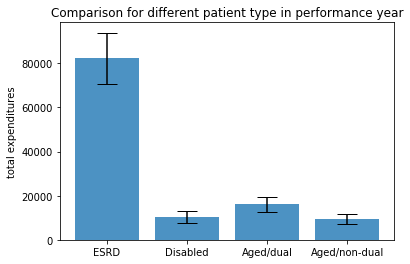

In [7]:
x_type = data[['Per_Capita_Exp_ALL_ESRD_PY', 'Per_Capita_Exp_ALL_DIS_PY', 'Per_Capita_Exp_ALL_AGDU_PY', 'Per_Capita_Exp_ALL_AGND_PY']]
plt.bar(['ESRD', 'Disabled', 'Aged/dual', 'Aged/non-dual'], x_type.mean(), yerr=x_type.std(), align='center', alpha=0.8, ecolor='black', capsize=10)
plt.ylabel('total expenditures')
plt.title('Comparison for different patient type in performance year')

### How does the distribution of the total expenditures look like?

Text(0.5, 1.0, 'Per capita ALL expenditures in performance year')

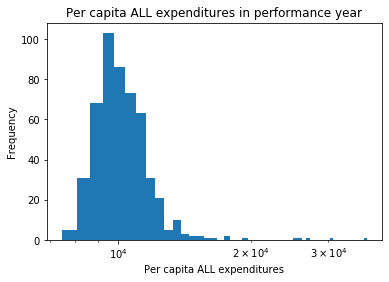

In [8]:
plt.hist(data['Per_Capita_Exp_TOTAL_PY'], bins=50)
plt.xscale('log')
plt.xlabel('Per capita ALL expenditures')
plt.ylabel('Frequency')
plt.title('Per capita ALL expenditures in performance year')

### What is the distribution for medical groups that paticipate in ACO?

Text(0.5, 1.0, 'Total number of the facilities paticipating in ACO')

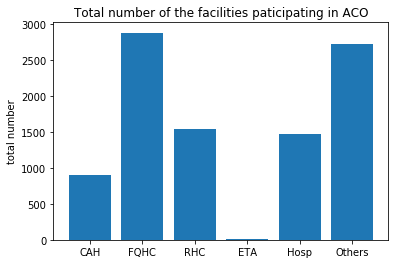

In [9]:
x_group = data[['N_CAH', 'N_FQHC', 'N_RHC', 'N_ETA', 'N_Hosp', 'N_Fac_Other']].sum()
plt.bar(['CAH', 'FQHC','RHC', 'ETA', 'Hosp', 'Others'], x_group)
plt.ylabel('total number')
plt.title('Total number of the facilities paticipating in ACO')

Text(0.5, 1.0, 'Total number of the individuals paticipating in ACO')

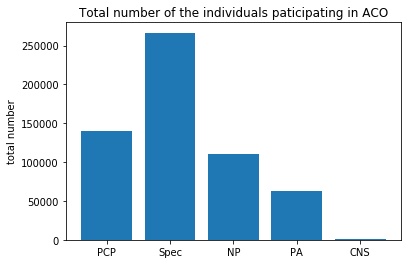

In [10]:
x_group = data[['N_PCP', 'N_Spec', 'N_NP', 'N_PA', 'N_CNS']].sum()
plt.bar(['PCP', 'Spec','NP', 'PA', 'CNS'], x_group)
plt.ylabel('total number')
plt.title('Total number of the individuals paticipating in ACO')

In [11]:
#Program Facts

#Number of ACOs
print(f"Number of ACOs: {len(data)}")

#Total Number of Attributed Beneficiaries
print(f"Total Number of Beneficiaries: {sum(data['N_AB'])}")

#Avg Number of Attributed Beneficiaries 
print(f"Average Number of Beneficiaries per ACO: {sum(data['N_AB'])/len(data):.0f}")

Number of ACOs: 513
Total Number of Beneficiaries: 10614589
Average Number of Beneficiaries per ACO: 20691


Total Savings Generated by ACOs: $4144939915
Total Savings Generated for CMS: $1861215125
Total Savings Generated per ACO: $8079805
Total Savings Generated  per Beneficary: $390


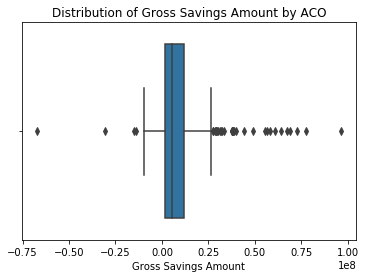

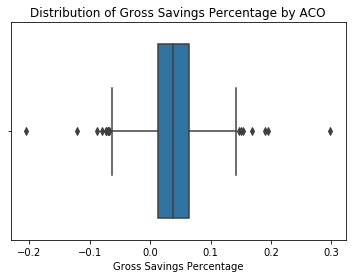

In [12]:
#Program Results

#Savings Generated by ACOs Relative to Benchmark
savings_generated = sum(data['BnchmkMinExp'])
print(f"Total Savings Generated by ACOs: ${savings_generated}")

#Total Savings Generated for CMS post ACO payouts
savings_to_CMS = sum(data['BnchmkMinExp'])-sum(data['EarnSaveLoss'])
print(f"Total Savings Generated for CMS: ${savings_to_CMS}")

#Savings per ACO
savings_per_ACO = savings_generated / len(data)
print(f"Total Savings Generated per ACO: ${savings_per_ACO:.0f}")

#Savings per beneficiary
savings_per_capita = savings_generated / sum(data['N_AB'])
print(f"Total Savings Generated  per Beneficary: ${savings_per_capita:.0f}")

#Distribution of Savings Generated by ACOs - Gross Savings/(Loss) Amount
sns.boxplot(data['BnchmkMinExp'])
plt.xlabel("Gross Savings Amount")
plt.title("Distribution of Gross Savings Amount by ACO")
plt.show()


#Distribution of Savings Generated by ACOs - Gross Savings/(Loss) Percentage
sns.boxplot(data['Sav_rate'])
plt.xlabel("Gross Savings Percentage")
plt.title("Distribution of Gross Savings Percentage by ACO")
plt.show()



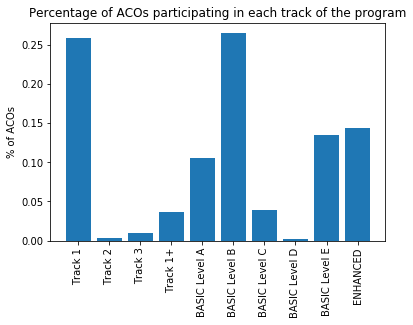

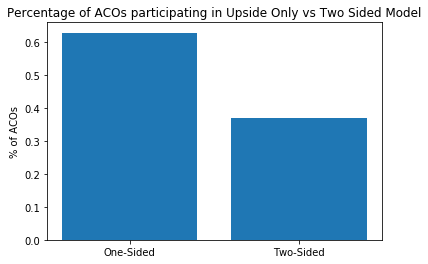

In [13]:
#ACO Characteristics

#Risk Track - Track 1, 2, 3, 1+, BASIC Levels A-E, ENHANCED
x = ["Track 1", "Track 2", "Track 3", "Track 1+", "BASIC Level A", "BASIC Level B", 
    "BASIC Level C","BASIC Level D","BASIC Level E","ENHANCED"]
y = [np.average(data['Current_Track_1']), np.average(data['Current_Track_2']), 
     np.average(data['Current_Track_3']), np.average(data['Current_Track_1_Plus']),
    np.average(data['Current_BASIC_A']), np.average(data['Current_BASIC_B']),
    np.average(data['Current_BASIC_C']), np.average(data['Current_BASIC_D']),
    np.average(data['Current_BASIC_E']), np.average(data['Current_ENHANCED']),
    ]

plt.bar(x, y)
plt.ylabel("% of ACOs")
plt.title("Percentage of ACOs participating in each track of the program")
plt.xticks(rotation="vertical")
plt.show()

#print(sum(y)) - sanity check

#Risk Profile - Track 1, BASIC A, and BASIC B are upside only, the remainder are two-sided models

#print(pd.unique(data['Risk_Model']))

x = ["One-Sided", "Two-Sided"]
y = [len(data[data['Risk_Model'] == x[0]])/len(data), len(data[data['Risk_Model'] == x[1]])/len(data)]

plt.bar(x, y)
plt.ylabel("% of ACOs")
plt.title("Percentage of ACOs participating in Upside Only vs Two Sided Model")
plt.show()


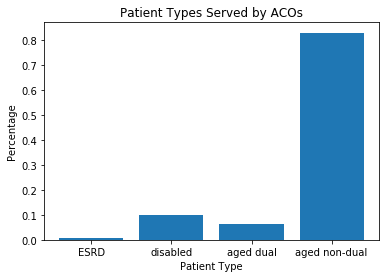

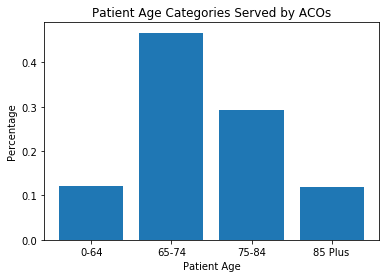

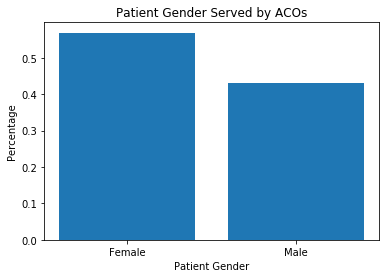

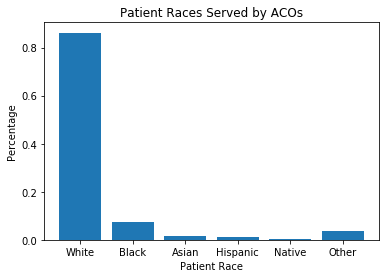

In [14]:
#Patient population

'''
CMS reports beneficiaries falling into certain categories (ESRD, Disabled, etc.) based on a notion of 
Patient-Years". This reflects the number of patients in each category under the care of the ACO, adjusted for how
many months of the current period the patient is under the ACO's care for.
'''

total_person_years = sum(data['N_AB_Year_PY'])
esrd = sum(data['N_AB_Year_ESRD_PY'])
disabled = sum(data['N_AB_Year_DIS_PY'])
aged_dual = sum(data['N_AB_Year_AGED_Dual_PY'])
aged_nondual = sum(data['N_AB_Year_AGED_NonDual_PY'])

x = ['ESRD', 'disabled', 'aged dual', 'aged non-dual']
y = np.array([esrd, disabled, aged_dual, aged_nondual])/total_person_years
plt.bar(x, y)
plt.title("Patient Types Served by ACOs")
plt.xlabel("Patient Type")
plt.ylabel("Percentage")
plt.show()

#Look at distribution of age

aged_0_64 = sum(data['N_Ben_Age_0_64'])
aged_65_74 = sum(data['N_Ben_Age_65_74'])
aged_75_84 = sum(data['N_Ben_Age_75_84'])
aged_85_plus = sum(data['N_Ben_Age_85plus'])

total = aged_0_64+aged_65_74+aged_75_84+aged_85_plus

x = ["0-64", "65-74", "75-84", "85 Plus"]
y = np.array([aged_0_64, aged_65_74, aged_75_84, aged_85_plus])
y  = y/sum(y)
plt.bar(x, y)
plt.title("Patient Age Categories Served by ACOs")
plt.xlabel("Patient Age")
plt.ylabel("Percentage")
plt.show()

#Look at distribution of gender

female = sum(data['N_Ben_Female'])
male = sum(data['N_Ben_Male'])

x=["Female", "Male"]
y=np.array([female, male])
y = y/sum(y)

plt.bar(x, y)
plt.title("Patient Gender Served by ACOs")
plt.xlabel("Patient Gender")
plt.ylabel("Percentage")
plt.show()

#Look at distribution of race

white = sum(data['N_Ben_Race_White'])
black = sum(data['N_Ben_Race_Black'])
asian = sum(data['N_Ben_Race_Asian'])
hispanic = sum(data['N_Ben_Race_Hisp'])
native = sum(data['N_Ben_Race_Native'])
other = sum(data['N_Ben_Race_Other'])



x=["White", "Black", "Asian", "Hispanic", "Native", "Other"]
y=np.array([white, black, asian, hispanic, native, other])
y = y/sum(y)

plt.bar(x, y)
plt.title("Patient Races Served by ACOs")
plt.xlabel("Patient Race")
plt.ylabel("Percentage")
plt.show()


Text(0.5, 1.0, 'Expenditures for different categories of hospital care')

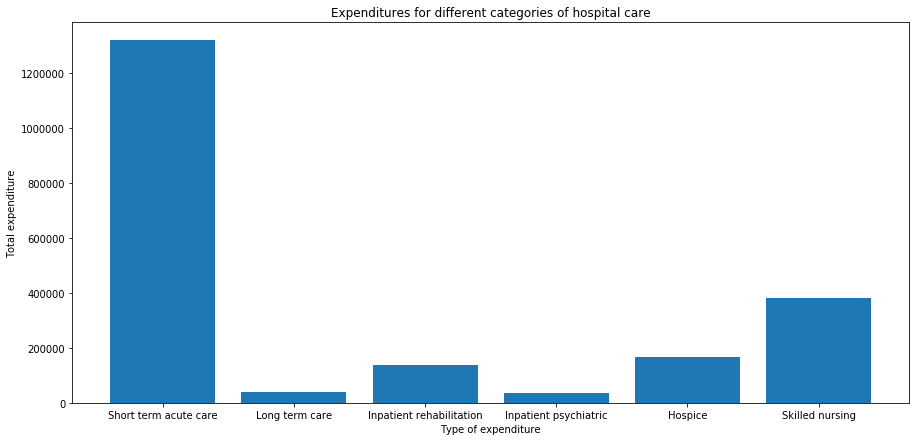

In [15]:
# Expenditures from several different sources
figure, ax = plt.subplots(1,1, figsize=(15,7))

x_group = data[['CapAnn_INP_S_trm', 'CapAnn_INP_L_trm', 'CapAnn_INP_Rehab', 'CapAnn_INP_Psych', 'CapAnn_HSP', 'CapAnn_SNF']].sum()
plt.bar(['Short term acute care', 'Long term care', 'Inpatient rehabilitation', 'Inpatient psychiatric',  'Hospice','Skilled nursing'], x_group)
plt.ylabel('Total expenditure')
plt.xlabel('Type of expenditure')
plt.title('Expenditures for different categories of hospital care')

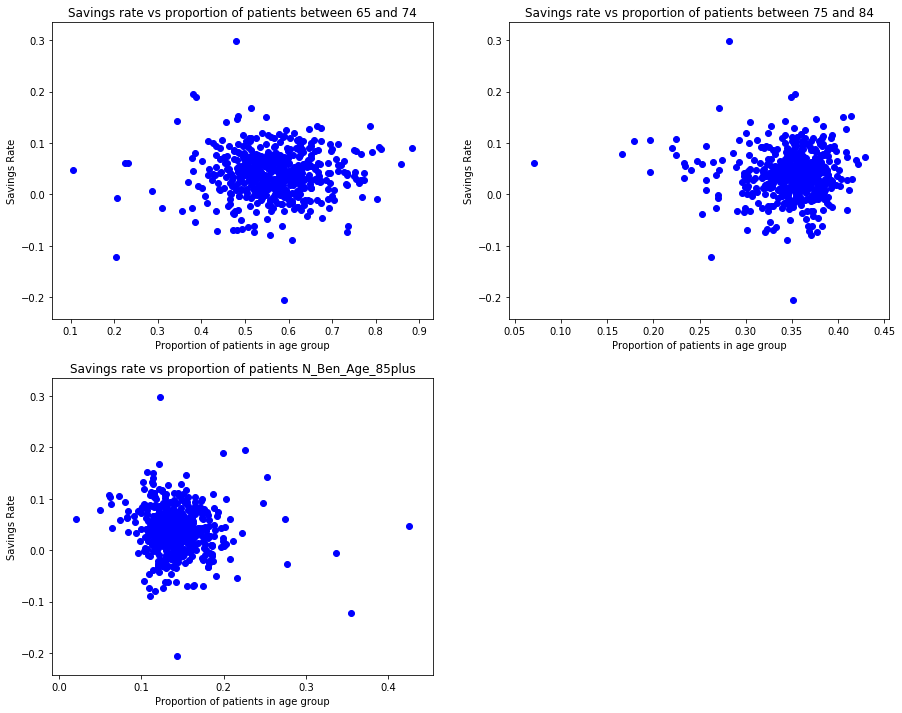

In [16]:
# Do ACOs with a higher proportion of older patients perform worse than ACOs that serve younger patients

figure, axs = plt.subplots(2,2, figsize=(15,12))
axs = axs.ravel()
axs[3].axis('off')

total_patients = data['N_Ben_Age_0_64'] + data['N_Ben_Age_75_84'] + data['N_Ben_Age_75_84'] + data['N_Ben_Age_85plus']
x_list = ['N_Ben_Age_65_74', 'N_Ben_Age_75_84', 'N_Ben_Age_85plus']
labels = ['between 65 and 74', 'between 75 and 84', 'N_Ben_Age_85plus']
for i in range(3):
    axs[i].scatter(data[x_list[i]]/total_patients , data['Sav_rate'], color='b')
    axs[i].set(title="Savings rate vs proportion of patients " + labels[i], xlabel="Proportion of patients in age group", ylabel="Savings Rate");

Text(0.5, 1.0, 'Savings Rate vs per capital ambulance expenditures')

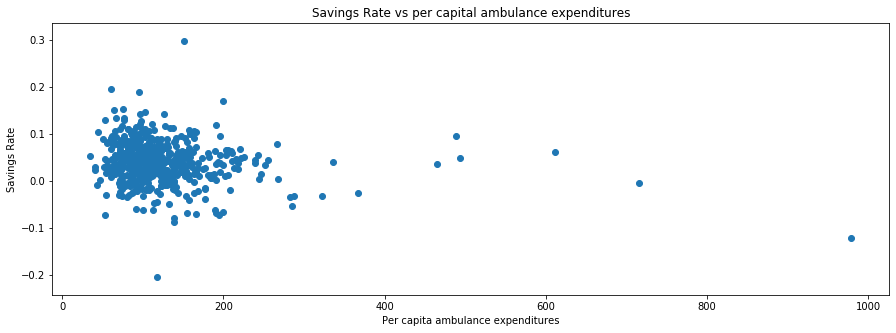

In [17]:
# Does a greater amount of ambulance expenditures reduce savings rate
figure, ax = plt.subplots(1,1, figsize=(15,5))
plt.scatter(data["CapAnn_AmbPay"], data['Sav_rate'])
plt.xlabel("Per capita ambulance expenditures")
plt.ylabel("Savings Rate")
plt.title("Savings Rate vs per capital ambulance expenditures")

# Testing Hypotheses

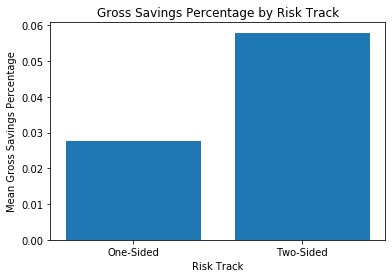

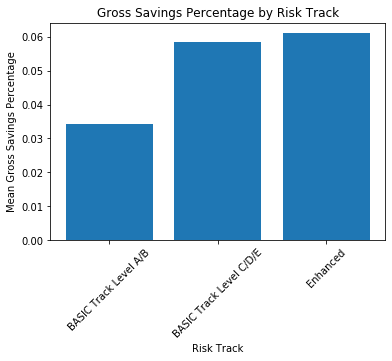

In [18]:
#Do ACOs that take on greater risk see more savings?

x = ["One-Sided", "Two-Sided"]
y = [np.mean(data[data['Risk_Model'] == x[0]]['Sav_rate']), np.mean(data[data['Risk_Model'] == x[1]]['Sav_rate'])]
plt.bar(x, y)
plt.xlabel("Risk Track")
plt.ylabel("Mean Gross Savings Percentage")
plt.title("Gross Savings Percentage by Risk Track")
plt.show()

x = ["BASIC Track Level A/B", "BASIC Track Level C/D/E", "Enhanced"]
y = [np.mean(data[(data['Current_BASIC_A'] == 1) | (data['Current_BASIC_B'] == 1)]['Sav_rate']), 
     np.mean(data[(data['Current_BASIC_C'] == 1) | (data['Current_BASIC_D'] == 1) | (data['Current_BASIC_E'] == 1)]['Sav_rate']),
    np.mean(data[(data['Current_ENHANCED'] == 1)]['Sav_rate'])]
plt.bar(x, y)
plt.xlabel("Risk Track")
plt.ylabel("Mean Gross Savings Percentage")
plt.title("Gross Savings Percentage by Risk Track")
plt.xticks(rotation="45")
plt.show()



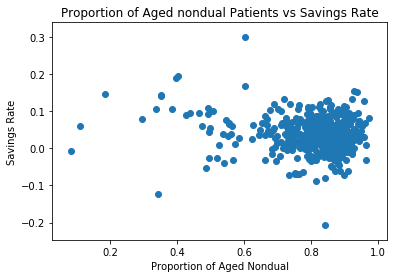

In [19]:
#Do ACOs that see sicker patients (ESRD, disabled, aged-dual) perform worse than ACOs that serve healthier patients?

data['prop_ESRD'] = data['N_AB_Year_ESRD_PY']/data['N_AB_Year_PY']
data['prop_disabled'] = data['N_AB_Year_DIS_PY']/data['N_AB_Year_PY']
data['prop_aged_dual'] = data['N_AB_Year_AGED_Dual_PY']/data['N_AB_Year_PY']
data['prop_aged_nondual'] = data['N_AB_Year_AGED_NonDual_PY']/data['N_AB_Year_PY']

plt.scatter(data['prop_aged_nondual'] , data['Sav_rate'])
plt.title("Proportion of Aged nondual Patients vs Savings Rate")
plt.xlabel("Proportion of Aged Nondual")
plt.ylabel("Savings Rate")
plt.show()


Text(0.5, 1.0, 'Number of Specialists vs Savings Rate')

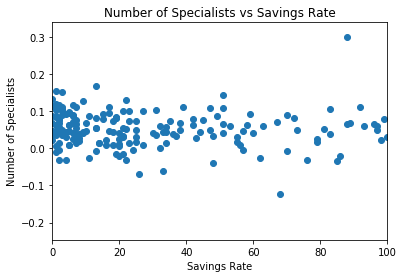

In [20]:
#Do ACOs with more specialists generate more savings?
plt.scatter(data["N_Spec"], data['Sav_rate'])
plt.xlim([0, 100])
plt.xlabel("Savings Rate")
plt.ylabel("Number of Specialists")
plt.title("Number of Specialists vs Savings Rate")

Text(0.5, 1.0, 'PCP Visits vs Savings Rate')

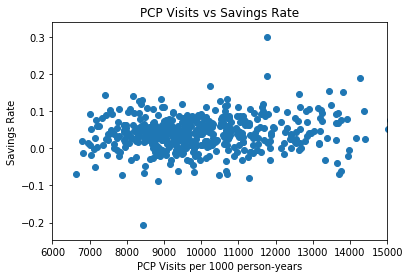

In [21]:
#Do more PCP visits correspond to more savings?
plt.scatter(data["P_EM_Total"], data['Sav_rate'])
plt.xlim([6000, 15000])
plt.xlabel("PCP Visits per 1000 person-years")
plt.ylabel("Savings Rate")
plt.title("PCP Visits vs Savings Rate")

Text(0.5, 1.0, 'Hospital Admissions vs Savings Rate')

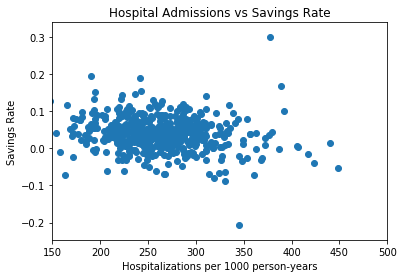

In [22]:
#Do more hospitalizations lead to fewer savings?
plt.scatter(data["ADM"], data['Sav_rate'])
plt.xlim([150, 500])
plt.xlabel("Hospitalizations per 1000 person-years")
plt.ylabel("Savings Rate")
plt.title("Hospital Admissions vs Savings Rate")

### Do total expenditures change with time for each type of patients?

Text(0.5, 1.0, 'Aged/non-dual')

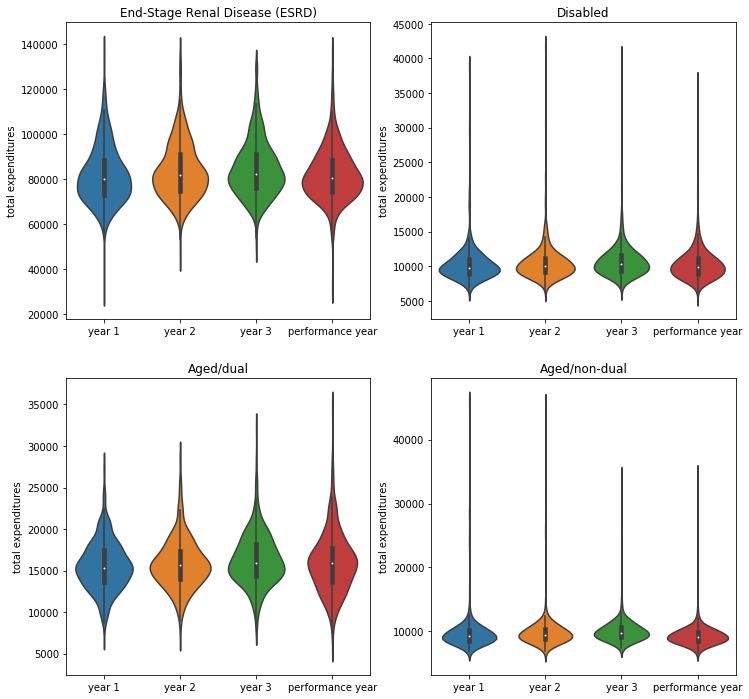

In [23]:
x_esrd = data[['Per_Capita_Exp_ALL_ESRD_BY1', 'Per_Capita_Exp_ALL_ESRD_BY2', 'Per_Capita_Exp_ALL_ESRD_BY3', 'Per_Capita_Exp_ALL_ESRD_PY']]
x_disabled = data[['Per_Capita_Exp_ALL_DIS_BY1', 'Per_Capita_Exp_ALL_DIS_BY2', 'Per_Capita_Exp_ALL_DIS_BY3', 'Per_Capita_Exp_ALL_DIS_PY']]
x_agdu = data[['Per_Capita_Exp_ALL_AGDU_BY1', 'Per_Capita_Exp_ALL_AGDU_BY2', 'Per_Capita_Exp_ALL_AGDU_BY3', 'Per_Capita_Exp_ALL_AGDU_PY']]
x_agnd = data[['Per_Capita_Exp_ALL_AGND_BY1', 'Per_Capita_Exp_ALL_AGND_BY2', 'Per_Capita_Exp_ALL_AGND_BY3', 'Per_Capita_Exp_ALL_AGND_PY']]

fig, ax = plt.subplots(2,2, figsize=(12,12))
sns.violinplot(data=x_esrd, ax=ax[0][0])
ax[0][0].set_xticklabels(['year 1', 'year 2', 'year 3', 'performance year'])
ax[0][0].set_ylabel('total expenditures')
ax[0][0].set_title('End-Stage Renal Disease (ESRD)')
sns.violinplot(data=x_disabled, ax=ax[0][1])
ax[0][1].set_xticklabels(['year 1', 'year 2', 'year 3', 'performance year'])
ax[0][1].set_ylabel('total expenditures')
ax[0][1].set_title('Disabled')
sns.violinplot(data=x_agdu, ax=ax[1][0])
ax[1][0].set_xticklabels(['year 1', 'year 2', 'year 3', 'performance year'])
ax[1][0].set_ylabel('total expenditures')
ax[1][0].set_title('Aged/dual')
sns.violinplot(data=x_agnd, ax=ax[1][1])
ax[1][1].set_xticklabels(['year 1', 'year 2', 'year 3', 'performance year'])
ax[1][1].set_ylabel('total expenditures')
ax[1][1].set_title('Aged/non-dual')

### Do different patient types result in different expenditures?

Text(0.5, 1.0, 'Comparison for different patient type in performance year')

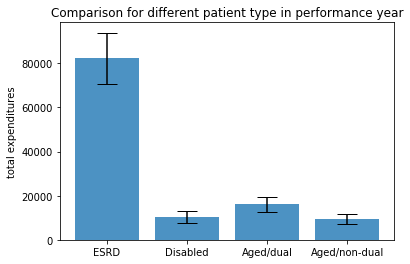

In [24]:
x_type = data[['Per_Capita_Exp_ALL_ESRD_PY', 'Per_Capita_Exp_ALL_DIS_PY', 'Per_Capita_Exp_ALL_AGDU_PY', 'Per_Capita_Exp_ALL_AGND_PY']]
plt.bar(['ESRD', 'Disabled', 'Aged/dual', 'Aged/non-dual'], x_type.mean(), yerr=x_type.std(), align='center', alpha=0.8, ecolor='black', capsize=10)
plt.ylabel('total expenditures')
plt.title('Comparison for different patient type in performance year')

### How does the distribution of the total expenditures look like?

Text(0.5, 1.0, 'Per capita ALL expenditures in performance year')

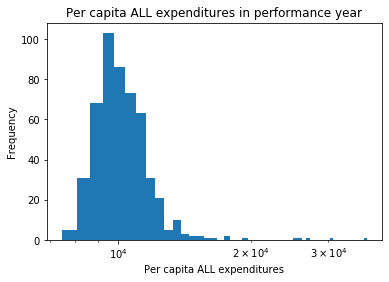

In [25]:
plt.hist(data['Per_Capita_Exp_TOTAL_PY'], bins=50)
plt.xscale('log')
plt.xlabel('Per capita ALL expenditures')
plt.ylabel('Frequency')
plt.title('Per capita ALL expenditures in performance year')

### Participation in the ACO in the performance year

### What is the distribution for medical groups that paticipate in ACO?

Text(0.5, 1.0, 'Total number of the facilities paticipating in ACO')

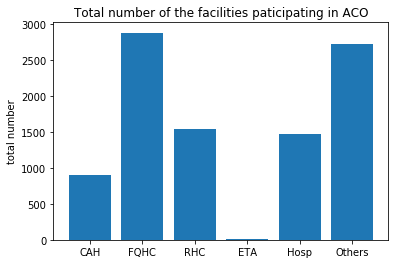

In [26]:
x_group = data[['N_CAH', 'N_FQHC', 'N_RHC', 'N_ETA', 'N_Hosp', 'N_Fac_Other']].sum()
plt.bar(['CAH', 'FQHC','RHC', 'ETA', 'Hosp', 'Others'], x_group)
plt.ylabel('total number')
plt.title('Total number of the facilities paticipating in ACO')

Text(0.5, 1.0, 'Total number of the individuals paticipating in ACO')

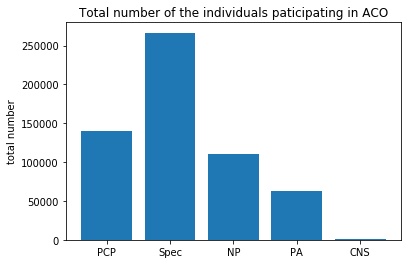

In [27]:
x_group = data[['N_PCP', 'N_Spec', 'N_NP', 'N_PA', 'N_CNS']].sum()
plt.bar(['PCP', 'Spec','NP', 'PA', 'CNS'], x_group)
plt.ylabel('total number')
plt.title('Total number of the individuals paticipating in ACO')

Text(0.5, 1.0, 'Expenditures for different categories of hospital care')

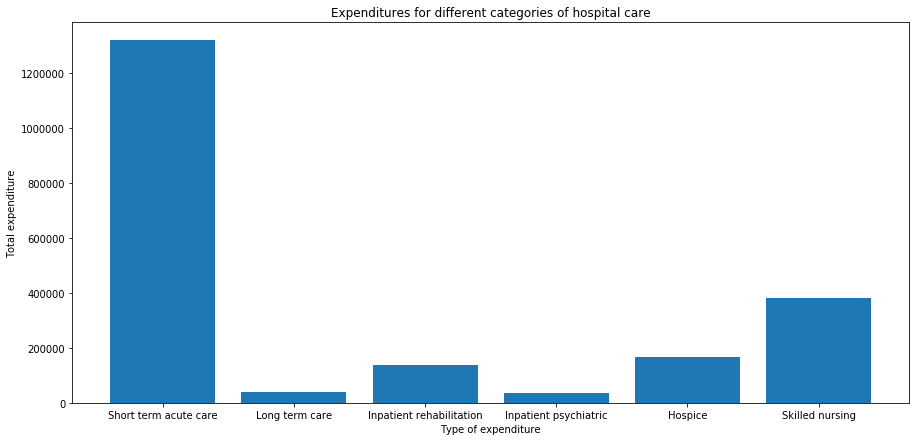

In [28]:
# Expenditures from several different sources
figure, ax = plt.subplots(1,1, figsize=(15,7))

x_group = data[['CapAnn_INP_S_trm', 'CapAnn_INP_L_trm', 'CapAnn_INP_Rehab', 'CapAnn_INP_Psych', 'CapAnn_HSP', 'CapAnn_SNF']].sum()
plt.bar(['Short term acute care', 'Long term care', 'Inpatient rehabilitation', 'Inpatient psychiatric',  'Hospice','Skilled nursing'], x_group)
plt.ylabel('Total expenditure')
plt.xlabel('Type of expenditure')
plt.title('Expenditures for different categories of hospital care')

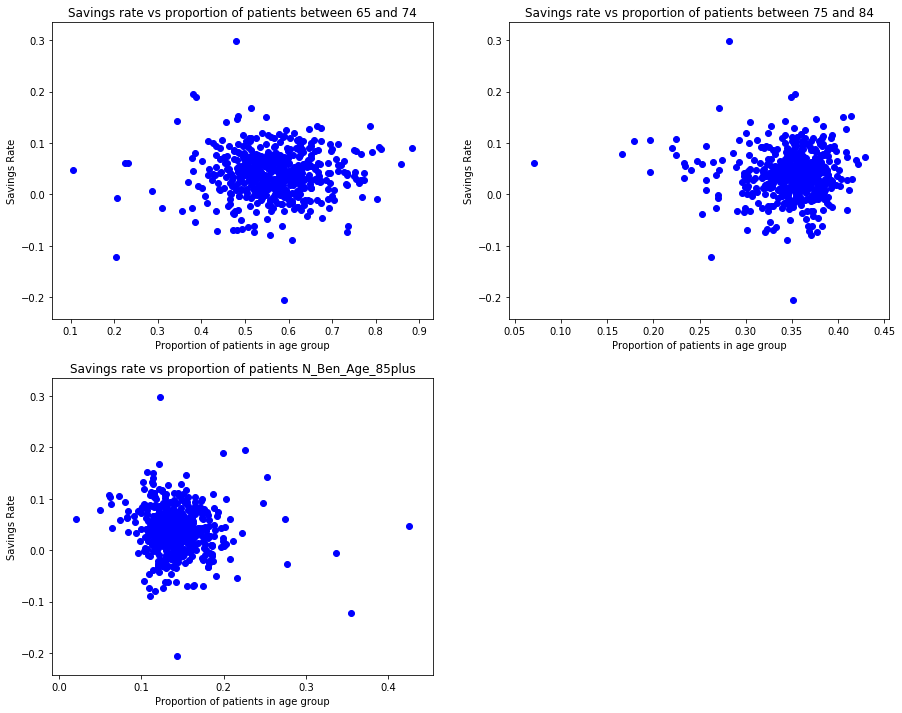

In [29]:
# Do ACOs with a higher proportion of older patients perform worse than ACOs that serve younger patients

figure, axs = plt.subplots(2,2, figsize=(15,12))
axs = axs.ravel()
axs[3].axis('off')

total_patients = data['N_Ben_Age_0_64'] + data['N_Ben_Age_75_84'] + data['N_Ben_Age_75_84'] + data['N_Ben_Age_85plus']
x_list = ['N_Ben_Age_65_74', 'N_Ben_Age_75_84', 'N_Ben_Age_85plus']
labels = ['between 65 and 74', 'between 75 and 84', 'N_Ben_Age_85plus']
for i in range(3):
    axs[i].scatter(data[x_list[i]]/total_patients , data['Sav_rate'], color='b')
    axs[i].set(title="Savings rate vs proportion of patients " + labels[i], xlabel="Proportion of patients in age group", ylabel="Savings Rate");

Text(0.5, 1.0, 'Savings Rate vs per capital ambulance expenditures')

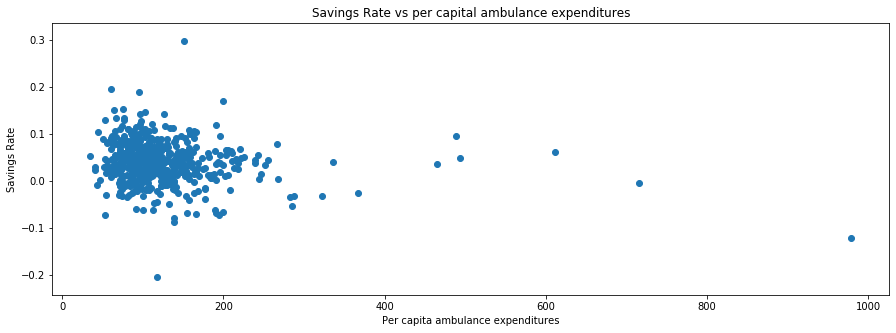

In [30]:
# Does a greater amount of ambulance expenditures reduce savings rate
figure, ax = plt.subplots(1,1, figsize=(15,5))
plt.scatter(data["CapAnn_AmbPay"], data['Sav_rate'])
plt.xlabel("Per capita ambulance expenditures")
plt.ylabel("Savings Rate")
plt.title("Savings Rate vs per capital ambulance expenditures")

### Columns with the smallest absolute values

In [31]:
data.describe().iloc[3].loc[np.abs(data.describe().iloc[3]) <= np.abs(np.mean(data.describe().iloc[3]))]

Agreement_Period_Num          1.000e+00
Current_Track_1               0.000e+00
Current_Track_2               0.000e+00
Current_Track_3               0.000e+00
Current_Track_1_Plus          0.000e+00
Current_BASIC_A               0.000e+00
Current_BASIC_B               0.000e+00
Current_BASIC_C               0.000e+00
Current_BASIC_D               0.000e+00
Current_BASIC_E               0.000e+00
Current_ENHANCED              0.000e+00
Adv_Pay                       0.000e+00
AIM                           0.000e+00
SNF_Waiver                    0.000e+00
Sav_rate                     -2.058e-01
MinSavPerc                    0.000e+00
EarnSaveLoss                  0.000e+00
DisAffQual                    1.000e+00
Met_QPS                       1.000e+00
QualScore                     9.687e+01
RecvdMean                     0.000e+00
RegTrndUpdt                   0.000e+00
PosRegAdj                     0.000e+00
Adv_Pay_Amt                   0.000e+00
Adv_Pay_Recoup                0.000e+00


### Columns with missing values

In [32]:
data.isnull().sum().loc[data.isnull().sum() > 0]

DisAdj            512
PosRegAdj         101
Adv_Pay_Amt       488
Adv_Pay_Recoup    488
ACO17               1
ACO42               2
ACO40               5
dtype: int64

### How does the saving rate vary with performance year Risk Model?

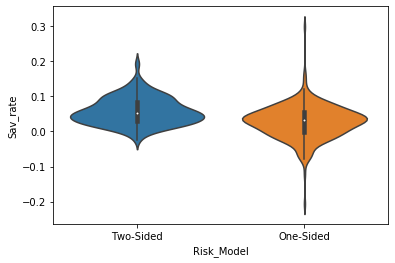

In [33]:
x_risk = data[['Risk_Model', 'Sav_rate']]
fig, ax = plt.subplots()
sns.violinplot(data=x_risk, x='Risk_Model', y='Sav_rate', ax=ax);

### How do average risk scores vary for different patient types accross time?

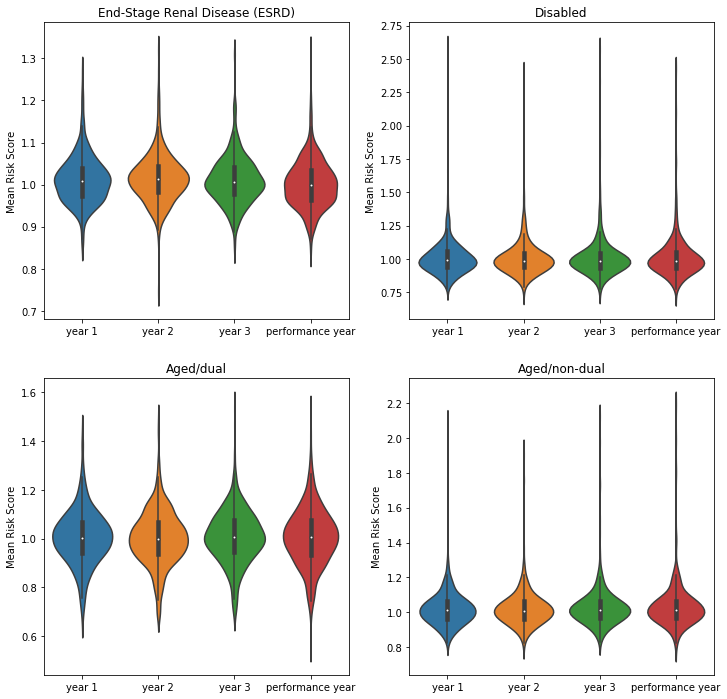

In [34]:
x_esrd = data[['CMS_HCC_RiskScore_ESRD_BY1', 'CMS_HCC_RiskScore_ESRD_BY2', 'CMS_HCC_RiskScore_ESRD_BY3', 'CMS_HCC_RiskScore_ESRD_PY']]
x_dis = data[['CMS_HCC_RiskScore_DIS_BY1', 'CMS_HCC_RiskScore_DIS_BY2', 'CMS_HCC_RiskScore_DIS_BY3', 'CMS_HCC_RiskScore_DIS_PY']]
x_agdu = data[['CMS_HCC_RiskScore_AGDU_BY1', 'CMS_HCC_RiskScore_AGDU_BY2', 'CMS_HCC_RiskScore_AGDU_BY3', 'CMS_HCC_RiskScore_AGDU_PY']]
x_agnd = data[['CMS_HCC_RiskScore_AGND_BY1', 'CMS_HCC_RiskScore_AGND_BY2', 'CMS_HCC_RiskScore_AGND_BY3', 'CMS_HCC_RiskScore_AGND_PY']]

fig, ax = plt.subplots(2,2, figsize=(12,12))
sns.violinplot(data=x_esrd, ax=ax[0][0])
ax[0][0].set_xticklabels(['year 1', 'year 2', 'year 3', 'performance year'])
ax[0][0].set_ylabel('Mean Risk Score')
ax[0][0].set_title('End-Stage Renal Disease (ESRD)')
sns.violinplot(data=x_dis, ax=ax[0][1])
ax[0][1].set_xticklabels(['year 1', 'year 2', 'year 3', 'performance year'])
ax[0][1].set_ylabel('Mean Risk Score')
ax[0][1].set_title('Disabled')
sns.violinplot(data=x_agdu, ax=ax[1][0])
ax[1][0].set_xticklabels(['year 1', 'year 2', 'year 3', 'performance year'])
ax[1][0].set_ylabel('Mean Risk Score')
ax[1][0].set_title('Aged/dual')
sns.violinplot(data=x_agnd, ax=ax[1][1])
ax[1][1].set_xticklabels(['year 1', 'year 2', 'year 3', 'performance year'])
ax[1][1].set_ylabel('Mean Risk Score')
ax[1][1].set_title('Aged/non-dual');

### What services were frequently rendered?

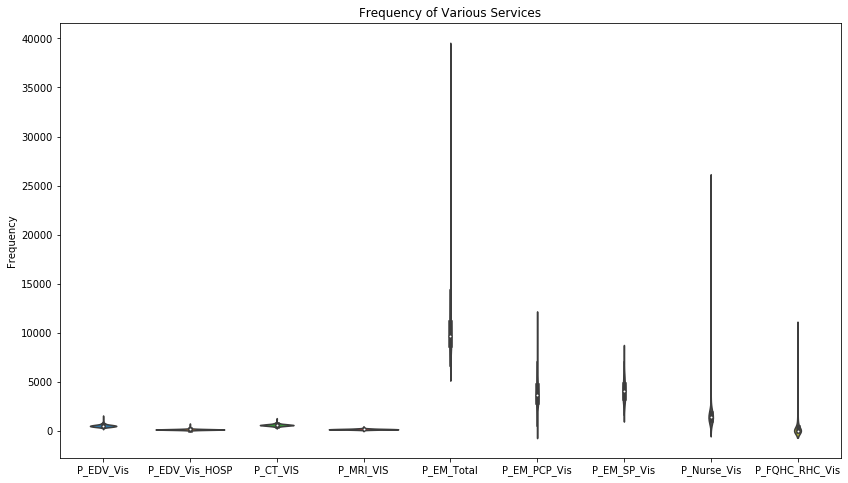

In [35]:
x_services = data[['P_EDV_Vis',
                   'P_EDV_Vis_HOSP',
                   'P_CT_VIS',
                   'P_MRI_VIS',
                   'P_EM_Total',
                   'P_EM_PCP_Vis',
                   'P_EM_SP_Vis',
                   'P_Nurse_Vis',
                   'P_FQHC_RHC_Vis']]
fig, ax = plt.subplots(figsize=(14,8))
sns.violinplot(data=x_services, ax=ax)
ax.set(
    xticklabels = ['P_EDV_Vis',
                   'P_EDV_Vis_HOSP',
                   'P_CT_VIS',
                   'P_MRI_VIS',
                   'P_EM_Total',
                   'P_EM_PCP_Vis',
                   'P_EM_SP_Vis',
                   'P_Nurse_Vis',
                   'P_FQHC_RHC_Vis'],
    ylabel = "Frequency",
    title = "Frequency of Various Services"
);

In [36]:
x_services.describe()

P_EDV_Vis  P_EDV_Vis_HOSP  P_CT_VIS  P_MRI_VIS  P_EM_Total  \
count    513.000         513.000   513.000    513.000     513.000   
mean     579.491         192.696   648.536    218.076   10234.051   
std      134.149          61.828   104.945     49.062    2592.593   
min      287.000          31.000   343.000     39.000    6641.000   
25%      494.000         162.000   586.000    187.000    8828.000   
50%      561.000         187.000   640.000    213.000    9723.000   
75%      641.000         216.000   706.000    243.000   11088.000   
max     1534.000         762.000  1282.000    481.000   38057.000   

       P_EM_PCP_Vis  P_EM_SP_Vis  P_Nurse_Vis  P_FQHC_RHC_Vis  
count       513.000      513.000      513.000         513.000  
mean       3933.805     4164.651     1625.329         510.238  
std        1659.656     1133.525     1506.568        1151.451  
min         258.000     1639.000      351.000           0.000  
25%        3002.000     3354.000     1149.000          15.000  
50%        3659.000     4127.000     1467.000          46.000  
75%        4675.000     4835.000     1869.000         418.000  
max       11256.000     8136.000    25304.000       10496.000

# Baseline Modelling

## Random Forest

In [37]:
#Baseline Model

#all of these are directly tied to the response variable and as such we do not want them as predictors
vars_to_exclude = ["EarnSaveLoss", "GenSaveLoss", "BnchmkMinExp", 'Current_Track_1', 'Current_Track_2', 'Current_Track_3',
                   'Current_Track_1_Plus', 'Current_BASIC_A', 'Current_BASIC_B', 'Current_BASIC_C', 'Current_BASIC_D',
                   'Current_BASIC_E', 'Current_ENHANCED'] 
data_mod = data.drop(vars_to_exclude, axis=1)

#Drop non-relevant categorial columns
cat_cols_to_encode = ["Rev_Exp_Cat", "Risk_Model", "Agree_Type"]
cols = data_mod.columns
num_cols = data_mod._get_numeric_data().columns
vars_to_exclude = list(set(cols) - set(num_cols) - set(cat_cols_to_encode))
data_mod = data_mod.drop(vars_to_exclude, axis=1)

#one-hot encode relevant categorial columns
data_mod = pd.get_dummies(data_mod, columns=cat_cols_to_encode)

nans = ['DisAdj', 'PosRegAdj', 'Adv_Pay_Amt','Adv_Pay_Recoup']
data_mod = data_mod.drop(nans, axis=1)

X = data_mod.drop(['Sav_rate', 'Risk_Model_One-Sided'], axis=1)
y = data_mod['Sav_rate']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8, random_state=34)

Random Forest Training Score: 0.907
Random Forest Test Score: 0.395


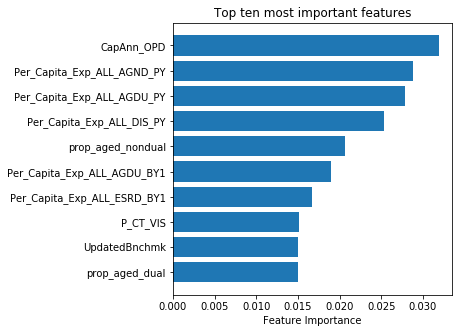

In [38]:
# Create and train Random Forest Regressor
rf = RandomForestRegressor(max_features='sqrt', random_state=30)
rf.fit(X_train, y_train)

print(f"Random Forest Training Score: {rf.score(X_train, y_train):.3f}")
print(f"Random Forest Test Score: {rf.score(X_test, y_test):.3f}")

# Find most important feautres
cols = X.columns
feat_importances = rf.feature_importances_

importance, features = (list(t) for t in zip(*sorted(zip(feat_importances, cols))))

figure, ax = plt.subplots(figsize=(5,5))

ax.barh(np.arange(10), importance[-10: ], align='center', tick_label=features[-10: ])
ax.set_xlabel('Feature Importance')
ax.set_title('Top ten most important features')

plt.show()

# Data prep

In [154]:
#all of these are directly tied to the response variable and as such we do not want them as predictors
vars_to_exclude = ["EarnSaveLoss", "GenSaveLoss", "BnchmkMinExp", 'Current_Track_1', 'Current_Track_2', 'Current_Track_3',
                   'Current_Track_1_Plus', 'Current_BASIC_A', 'Current_BASIC_B', 'Current_BASIC_C', 'Current_BASIC_D',
                   'Current_BASIC_E', 'Current_ENHANCED', 'Adv_Pay', 'RevLossLimit'] 
data_mod = data.drop(vars_to_exclude, axis=1)

#Drop non-relevant categorial columns
cat_cols_to_encode = ["Rev_Exp_Cat", "Risk_Model", "Agree_Type"]
cols = data_mod.columns
num_cols = data_mod._get_numeric_data().columns
vars_to_exclude = list(set(cols) - set(num_cols) - set(cat_cols_to_encode))
data_mod = data_mod.drop(vars_to_exclude, axis=1)

#one-hot encode relevant categorial columns
data_mod = pd.get_dummies(data_mod, columns=cat_cols_to_encode)

nans = ['DisAdj', 'PosRegAdj', 'Adv_Pay_Amt','Adv_Pay_Recoup']
data_mod = data_mod.drop(nans, axis=1)

X = data_mod.drop(['Sav_rate', 'Risk_Model_One-Sided'], axis=1)
y = data_mod['Sav_rate']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8, random_state=34)

# PCA

## Checking for multicolinearity

In [132]:
corr=data.corr()
corr.style.background_gradient(cmap='coolwarm')

D:\Users\aaron\Anaconda3\lib\site-packages\pandas\io\formats\style.py:1264: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(s.to_numpy()) if vmin is None else vmin
D:\Users\aaron\Anaconda3\lib\site-packages\pandas\io\formats\style.py:1265: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(s.to_numpy()) if vmax is None else vmax


## PCA

In [133]:
# scale data for PCA
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [134]:
# Perform PCA
pca = PCA().fit(X_train_scaled)
X_train_pca = pca.transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

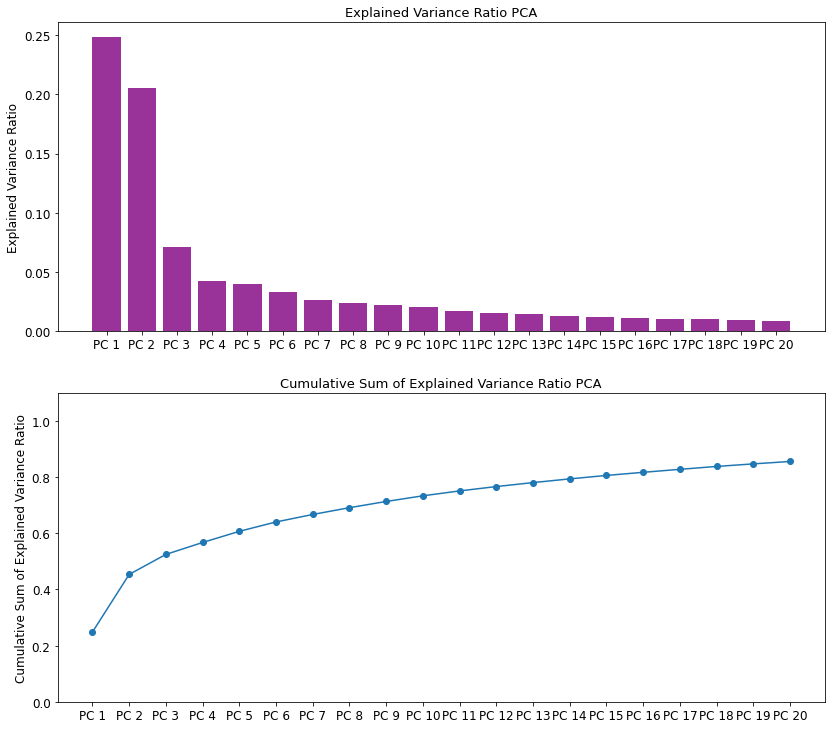

In [144]:
# Plot explained variance for pca components
fig, ax = plt.subplots(nrows=2, figsize=(5.5*fig_scale, 5*fig_scale))
ax1, ax2 = ax.ravel()

ratio = pca.explained_variance_ratio_
num_components = 20
ax1.bar(range(num_components), ratio[ :num_components], color='purple', alpha=0.8)
ax1.set_title('Explained Variance Ratio PCA', fontsize=text_size+1)
ax1.set_xticks(range(num_components))
ax1.set_xticklabels(['PC {}'.format(i+1) for i in range(num_components)])
ax1.set_ylabel('Explained Variance Ratio', fontsize=text_size)
ax1.tick_params(axis='x', labelsize=text_size)
ax1.tick_params(axis='y', labelsize=text_size)

ratio = pca.explained_variance_ratio_
ax2.plot(np.cumsum(ratio[ :num_components]), 'o-')

ax2.set_title('Cumulative Sum of Explained Variance Ratio PCA', fontsize=text_size+1)

ax2.set_ylim(0,1.1)
ax2.set_xticks(range(num_components))
ax2.set_xticklabels(['PC {}'.format(i+1) for i in range(num_components)])
ax2.set_ylabel('Cumulative Sum of Explained Variance Ratio', fontsize=text_size);
ax2.tick_params(axis='x', labelsize=text_size)
ax2.tick_params(axis='y', labelsize=text_size)

#plt.savefig('Project_images/PCA_explained_variance.pdf', bbox_inches="tight")

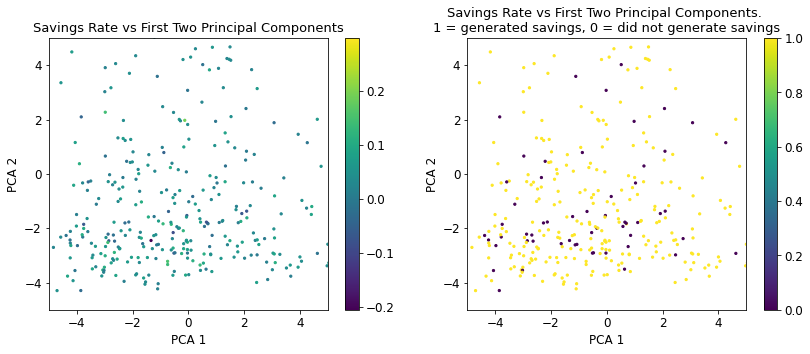

In [147]:
#Observe Classification Boundary with first two components
figure, axs = plt.subplots(1,2, figsize=(5.5*fig_scale, 2*fig_scale))
axs = axs.ravel()
cm = plt.cm.get_cmap('RdYlBu')
sc1 = axs[0].scatter(X_train_pca[:,0], X_train_pca[:,1], c = y_train, s=2*fig_scale)
axs[0].set_xlim([-5, 5])
axs[0].set_ylim([-5, 5])
axs[0].set_xlabel("PCA 1", fontsize=text_size)
axs[0].set_ylabel("PCA 2", fontsize=text_size)
axs[0].tick_params(axis='x', labelsize=text_size)
axs[0].tick_params(axis='y', labelsize=text_size)
axs[0].set_title("Savings Rate vs First Two Principal Components", fontsize=text_size+1)
cbar = fig.colorbar(sc1, ax = axs[0])
cbar.ax.tick_params(labelsize=text_size)

sc2 = axs[1].scatter(X_train_pca[:,0], X_train_pca[:,1], c = [1 if y_i >= 0 else 0 for y_i in y_train], s=2*fig_scale)
axs[1].set_xlim([-5, 5])
axs[1].set_ylim([-5, 5])
axs[1].set_xlabel("PCA 1", fontsize=text_size)
axs[1].set_ylabel("PCA 2", fontsize=text_size)
axs[1].tick_params(axis='x', labelsize=text_size)
axs[1].tick_params(axis='y', labelsize=text_size)
axs[1].set_title("Savings Rate vs First Two Principal Components. \n1 = generated savings, 0 = did not generate savings", fontsize=text_size+1)
cbar = fig.colorbar(sc2, ax = axs[1])
cbar.ax.tick_params(labelsize=text_size)
#plt.savefig('Project_images/PCA_two_components.pdf', bbox_inches="tight")
plt.show()



## PCA with Random Forest

In [138]:
# Create and train Random Forest Regressor
rf = RandomForestRegressor(max_features='sqrt', max_depth=12, random_state=32, n_estimators=275)
rf.fit(X_train_pca, y_train)

print(f"Random Forest Training Score: {rf.score(X_train_pca, y_train):.3f}")
print(f"Random Forest Test Score: {rf.score(X_test_pca, y_test):.3f}")

Random Forest Training Score: 0.862
Random Forest Test Score: 0.382


## PCA with Linear Regression

In [139]:
#Linear Regression with Cross Validation

lr_pca = LinearRegression()

n_components = 20

results = cross_validate(lr_pca, X_train_pca[:,:n_components], y_train, cv=10, scoring = 'neg_mean_squared_error', return_train_score=True)
train_mse_lr_pca = np.mean(-1*results['train_score'])
val_mse_lr_pca = np.mean(-1*results['test_score'])
val_mse_stds_lr_pca = np.std(-1*results['test_score'])
    
print(f"Mean training set MSE: {train_mse_lr_pca:.7f}. Mean validation set MSE: {val_mse_lr_pca:.7f} ")


#Overall Fitted Model
lr_pca.fit(X_train_pca[:,:n_components], y_train)
train_mse_lr_pca_full = mean_squared_error(lr_pca.predict(X_train_pca[:,:n_components]), y_train)
r2_train_lr_pca_full = r2_score(lr_pca.predict(X_train_pca[:,:n_components]), y_train)

test_mse_lr_pca_full = mean_squared_error(lr_pca.predict(X_test_pca[:,:n_components]), y_test)
r2_test_lr_pca_full = r2_score(lr_pca.predict(X_test_pca[:,:n_components]), y_test)

print(f"Overall training set MSE: {train_mse_lr_pca_full:.7f}. Overall test set MSE: {test_mse_lr_pca_full:.7f} ")
print(f"Overall training set R2: {r2_train_lr_pca_full:.3f}. Overall test set R2: {r2_test_lr_pca_full:.3f} ")


Mean training set MSE: 0.0010898. Mean validation set MSE: 0.0015801 
Overall training set MSE: 0.0011040. Overall test set MSE: 0.0008965 
Overall training set R2: 0.026. Overall test set R2: -0.089 


## PCA with KNN

In [191]:
cv_reduced_error = []
train_score_pca = []
for k_value in k_list:
    knn_model = KNeighborsRegressor(n_neighbors=k_value)
    knn_model.fit(X_train_pca, y_train)
    accu = cross_validate(knn_model, X_train_pca, y_train, scoring = 'r2', cv=10)['test_score'].mean()
    cv_reduced_error.append(accu)
    train_score = knn_model.score(X_train_pca, y_train)
    train_score_pca.append(train_score)

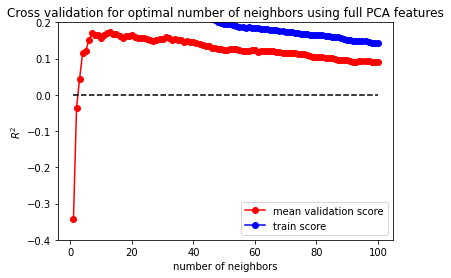

In [192]:
plt.plot(k_list, cv_reduced_error, 'ro-', label='mean validation score')
plt.plot(k_list, train_score_pca, 'bo-', label='train score')
plt.plot(k_list, np.zeros(len(k_list)), 'k--')
plt.xlabel('number of neighbors')
plt.ylabel('$R^2$')
plt.title('Cross validation for optimal number of neighbors using full PCA features')
plt.ylim(-0.4, 0.2)
plt.legend()

In [193]:
best_k = k_list[cv_reduced_error.index(max(cv_reduced_error))]
print('The best number of neighbors is: ', best_k)

The best number of neighbors is:  13


In [194]:
row, col = np.shape(X_train_pca)
cv_reduced_error = []

for i in range(col):
    knn_model = KNeighborsRegressor(n_neighbors=best_k)
    #knn_model.fit(X_train_pca, y_train)
    accu = cross_validate(knn_model, X_train_pca[:,:(i+1)], y_train, scoring = 'r2', cv=10)['test_score'].mean()
    cv_reduced_error.append(accu)

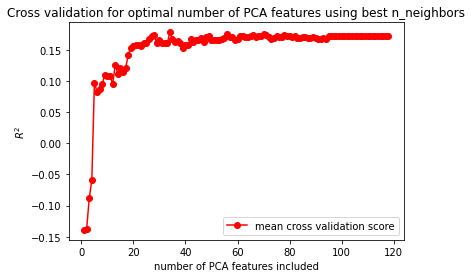

In [195]:
plt.plot([i+1 for i in range(col)], cv_reduced_error, 'ro-', label='mean cross validation score')
plt.xlabel('number of PCA features included')
plt.ylabel('$R^2$')
plt.title('Cross validation for optimal number of PCA features using best n_neighbors')
plt.legend()

In [196]:
num_pca = [i+1 for i in range(col)]
best_num_pca = num_pca[cv_reduced_error.index(max(cv_reduced_error))]
print('The best number of PCA features: ', best_num_pca)

The best number of PCA features:  34


In [197]:
model = KNeighborsRegressor(n_neighbors=best_k)
model.fit(X_train_pca[:, :best_num_pca], y_train)
train_accuracy = model.score(X_train_pca[:, :best_num_pca], y_train)
test_accuracy = model.score(X_test_pca[:, :best_num_pca], y_test)
print('The train accuracy using the best parameters is ', train_accuracy)
print('The test accuracy using the best parameters is ', test_accuracy)

The train accuracy using the best parameters is  0.336202754387002
The test accuracy using the best parameters is  0.226775076184062


# Models

## Random Forest Model

### Single regressor tree

In [5]:
max_depth = 40
cv_train_r2 = []
cv_val_r2 = []
cv_val_std = []
cv_train_mse = []
cv_test_mse = []

for tree_depth in range(1, max_depth+1):
    tree_model = DecisionTreeRegressor(max_depth=tree_depth, random_state=32)
    tree_model.fit(X_train, y_train)
    
    mse_score = cross_validate(DecisionTreeRegressor(max_depth=tree_depth, random_state=32), X_train, y_train, 
                               scoring='neg_mean_squared_error', cv=10, return_estimator=True, return_train_score=True)
    
    cv_train_mse.append(abs(mse_score['train_score']).mean())
    cv_test_mse.append(abs(mse_score['test_score']).mean())
    
    r2_train = []
    r2_validation = []
    for model in mse_score['estimator']:
        r2_train.append(model.score(X_train, y_train))
        r2_validation.append(model.score(X_test, y_test))
    
    cv_train_r2.append(np.mean(r2_train))
    cv_val_r2.append(np.mean(r2_validation))
    cv_val_std.append(np.std(r2_validation))

(-1.3913376989962536, 0.33584371581059613)

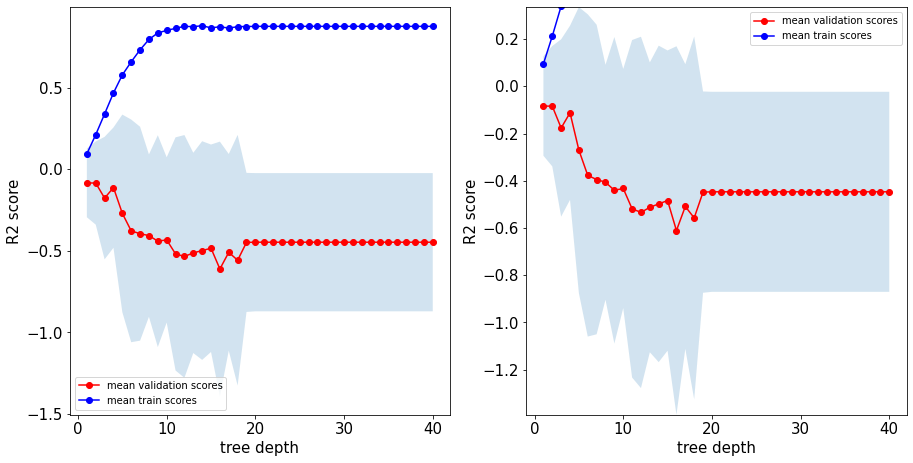

In [15]:
figure, axs = plt.subplots(1,2, figsize=(5*fig_scale, 2.5*fig_scale))
axs = axs.ravel()

for i in range(2):
    axs[i].plot(range(1, max_depth+1), cv_val_r2, 'o-', label='mean validation scores', color='r')
    axs[i].plot(range(1, max_depth+1), cv_train_r2, 'o-', label='mean train scores', color='b')
    axs[i].fill_between(range(1, max_depth+1), [a + 2*b for a, b in zip(cv_val_r2, cv_val_std)], [a - 2*b for a, b in zip(cv_val_r2, cv_val_std)], alpha=0.2)
    axs[i].set_xlabel('tree depth', fontsize=text_size)
    axs[i].set_ylabel('R2 score', fontsize=text_size)
    axs[i].tick_params(axis='x', labelsize=text_size)
    axs[i].tick_params(axis='y', labelsize=text_size)
    axs[i].legend()
axs[1].set_ylim(min([a - 2*b for a, b in zip(cv_val_r2, cv_val_std)]), max([a + 2*b for a, b in zip(cv_val_r2, cv_val_std)]))

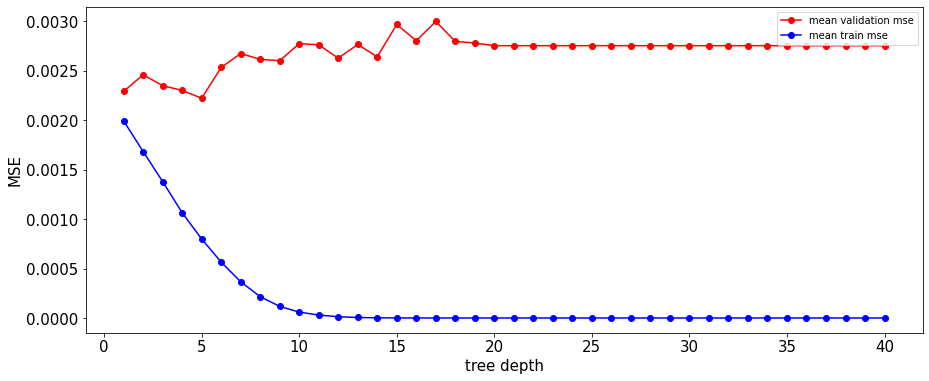

In [18]:
figure, ax = plt.subplots(figsize=(5*fig_scale, 2*fig_scale))

ax.plot(range(1, max_depth+1), cv_test_mse, 'o-', label='mean validation mse', color='r')
ax.plot(range(1, max_depth+1), cv_train_mse, 'o-', label='mean train mse', color='b')
ax.set_xlabel('tree depth', fontsize=text_size)
ax.set_ylabel('MSE', fontsize=text_size)
ax.tick_params(axis='x', labelsize=text_size)
ax.tick_params(axis='y', labelsize=text_size)
ax.legend()

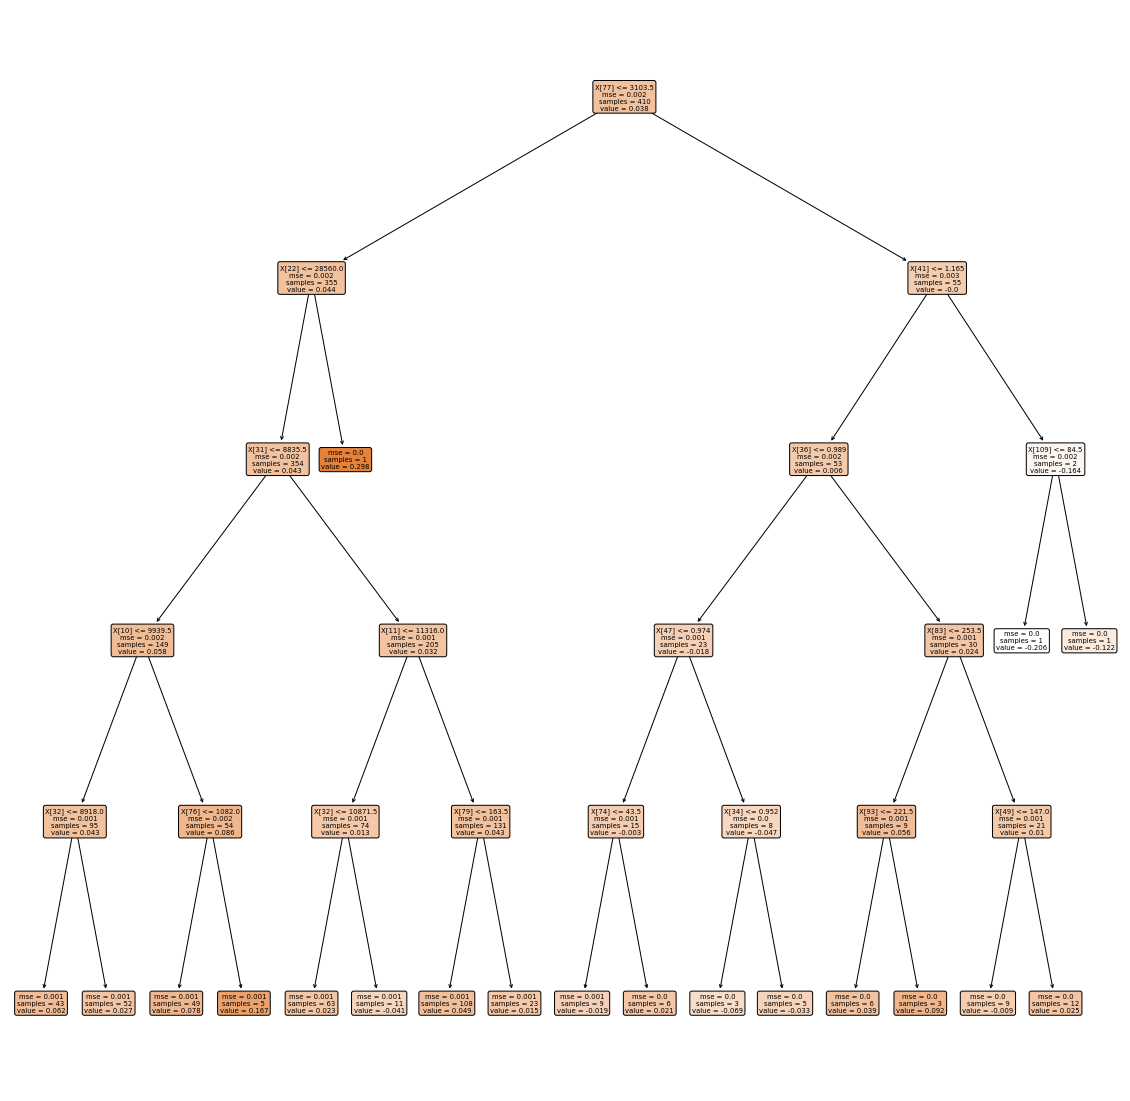

In [20]:
tree_model = DecisionTreeRegressor(max_depth=5, random_state=32)
tree_model.fit(X_train, y_train)

figure, ax = plt.subplots(figsize=(20, 20))

# Plot the Decision Tree trained above with parameters filled as True
tree.plot_tree(tree_model, filled=True, rounded=True, ax=ax)

plt.show()
#plt.savefig('Project_images/decision_tree.pdf', bbox_inches="tight")

In [21]:
print(X_train.columns[89], X_train.columns[30], X_train.columns[53])

prov_Rate_1000 Per_Capita_Exp_ALL_AGDU_PY N_AB_Year_PY


### Random Forest Model

In [227]:
max_depth = 40
cv_train_r2 = []
cv_val_r2 = []
cv_val_std = []
cv_train_mse = []
cv_test_mse = []

for tree_depth in range(1, max_depth+1):
    tree_model = RandomForestRegressor(max_features='sqrt', max_depth=tree_depth, random_state=32)
    tree_model.fit(X_train, y_train)
    
    mse_score = cross_validate(RandomForestRegressor(max_features='sqrt', max_depth=tree_depth, random_state=32), X_train, 
                               y_train, scoring='neg_mean_squared_error', cv=10, return_estimator=True, return_train_score=True)
    
    cv_train_mse.append(abs(mse_score['train_score']).mean())
    cv_test_mse.append(abs(mse_score['test_score']).mean())
    
    r2_train = []
    r2_validation = []
    for model in mse_score['estimator']:
        r2_train.append(model.score(X_train, y_train))
        r2_validation.append(model.score(X_test, y_test))
    
    cv_train_r2.append(np.mean(r2_train))
    cv_val_r2.append(np.mean(r2_validation))
    cv_val_std.append(np.std(r2_validation))

(0.018370782864983087, 0.4446889638287218)

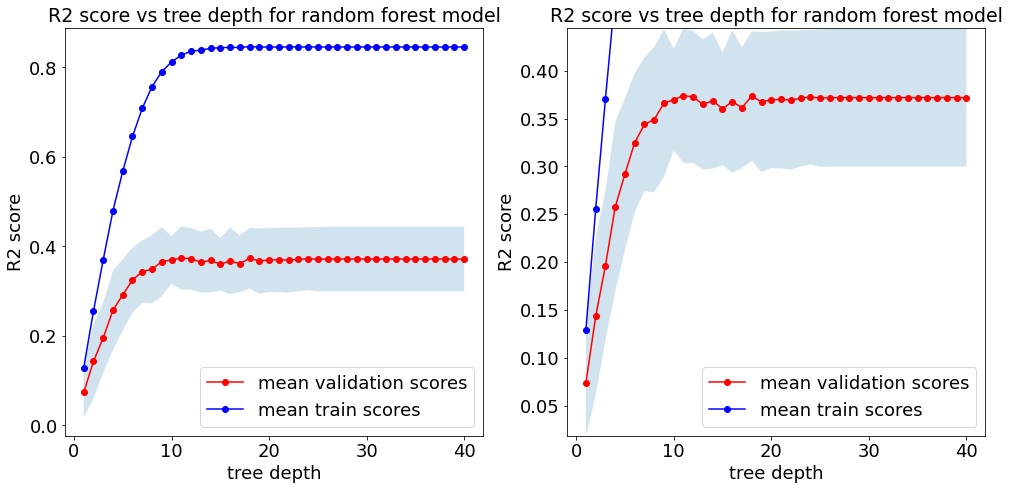

In [234]:
figure, axs = plt.subplots(1,2, figsize=(5.5*fig_scale, 2.5*fig_scale))
axs = axs.ravel()

for i in range(2):
    axs[i].plot(range(1, max_depth+1), cv_val_r2, 'o-', label='mean validation scores', color='r', markersize=2*fig_scale, linewidth=0.5*fig_scale)
    axs[i].plot(range(1, max_depth+1), cv_train_r2, 'o-', label='mean train scores', color='b', markersize=2*fig_scale, linewidth=0.5*fig_scale)
    axs[i].fill_between(range(1, max_depth+1), [a + 2*b for a, b in zip(cv_val_r2, cv_val_std)], [a - 2*b for a, b in zip(cv_val_r2, cv_val_std)], alpha=0.2)
    axs[i].set_xlabel('tree depth', fontsize=text_size)
    axs[i].set_ylabel('R2 score', fontsize=text_size)
    axs[i].tick_params(axis='x', labelsize=text_size)
    axs[i].tick_params(axis='y', labelsize=text_size)
    axs[i].set_title('R2 score vs tree depth for random forest model', fontsize=text_size+1)
    axs[i].legend(fontsize=text_size)
axs[1].set_ylim(min([a - 2*b for a, b in zip(cv_val_r2, cv_val_std)]), max([a + 2*b for a, b in zip(cv_val_r2, cv_val_std)]))

#plt.savefig('Project_images/rf_tree_depth.pdf', bbox_inches="tight")

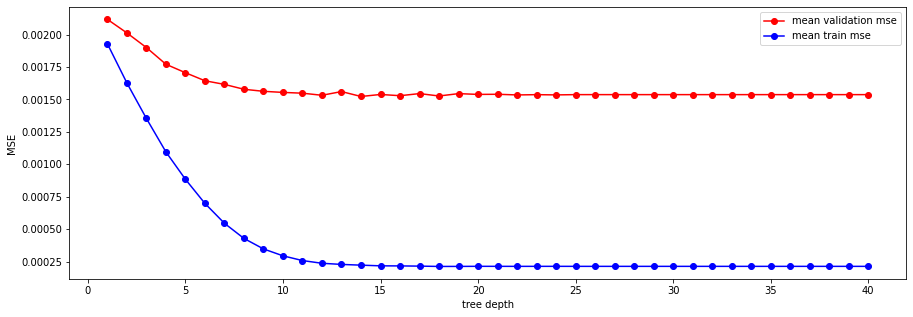

In [29]:
figure, ax = plt.subplots(figsize=(15,5))

ax.plot(range(1, max_depth+1), cv_test_mse, 'o-', label='mean validation mse', color='r')
ax.plot(range(1, max_depth+1), cv_train_mse, 'o-', label='mean train mse', color='b')
ax.set(xlabel='tree depth', ylabel='MSE')
ax.legend()

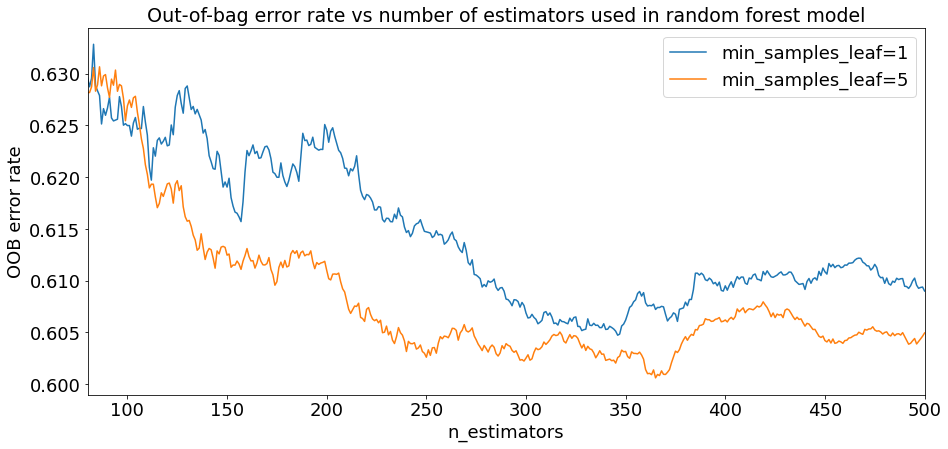

Wall time: 1min 34s


In [235]:
%%time

plt.subplots(figsize=(5*fig_scale, 2.25*fig_scale))

from collections import OrderedDict
ensemble_clfs = [
    (1,
        RandomForestRegressor(warm_start=True, 
                               min_samples_leaf=1,
                               oob_score=True,
                               max_depth = 12,
                               random_state=32)),
    (5,
        RandomForestRegressor(warm_start=True, 
                               min_samples_leaf=5,
                               oob_score=True,
                               max_depth = 12,
                               random_state=32))
]

# Map a label (the value of `min_samples_leaf`) to a list of (model, oob error) tuples.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

min_estimators = 80
max_estimators = 500

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1):
        clf.set_params(n_estimators=i) 
        clf.fit(X_train.values, y_train.values)

        # Record the OOB error for each model. Error is 1 - oob_score
        # oob_score: score of the training dataset obtained using an 
        # out-of-bag estimate.
        # OOB error rate is % of num_missclassified/total observations
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=f'min_samples_leaf={label}')

plt.xlim(min_estimators, max_estimators)
plt.title('Out-of-bag error rate vs number of estimators used in random forest model', fontsize=text_size+1)
plt.xlabel("n_estimators", fontsize=text_size)
plt.ylabel("OOB error rate", fontsize=text_size)
plt.legend(loc="upper right", fontsize=text_size)
plt.tick_params(axis='x', labelsize=text_size)
plt.tick_params(axis='y', labelsize=text_size)

#plt.savefig('Project_images/rf_oob_error_rate.pdf', bbox_inches="tight")

plt.show();


Random Forest Training Score: 0.895
Random Forest Test Score: 0.412


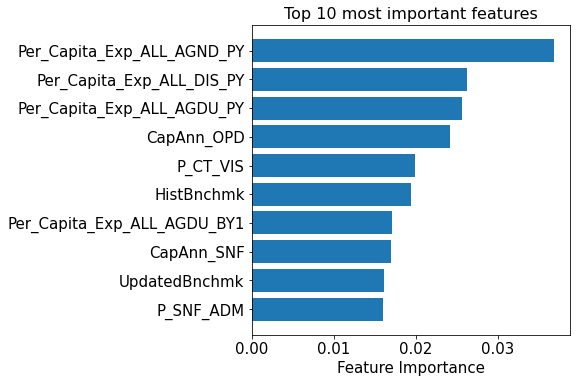

In [32]:
# Create and train Random Forest Regressor
rf = RandomForestRegressor(max_features='sqrt', max_depth=12, random_state=32, n_estimators=362)
rf.fit(X_train, y_train)

print(f"Random Forest Training Score: {rf.score(X_train, y_train):.3f}")
print(f"Random Forest Test Score: {rf.score(X_test, y_test):.3f}")

# Find most important feautres
cols = X.columns
feat_importances = rf.feature_importances_

importance, features = (list(t) for t in zip(*sorted(zip(feat_importances, cols))))

figure, ax = plt.subplots(figsize=(1.9*fig_scale, 1.9*fig_scale))

num_features = 10
ax.barh(np.arange(num_features), importance[-num_features: ], align='center', tick_label=features[-num_features: ])
ax.set_xlabel('Feature Importance', fontsize=text_size)
ax.set_title('Top 10 most important features', fontsize=text_size+1)
ax.tick_params(axis='x', labelsize=text_size)
ax.tick_params(axis='y', labelsize=text_size)

#plt.savefig('Project_images/rf_feature_importance.pdf', bbox_inches="tight")

plt.show()


In [33]:
perm = PermutationImportance(rf, random_state=32, n_iter=15).fit(X_test, y_test)
eli5.show_weights(perm, feature_names=X.columns.tolist())

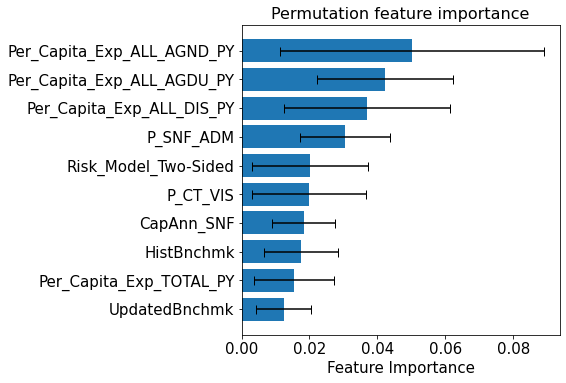

In [34]:
weights = [0.0503, 0.0422, 0.0370, 0.0304, 0.0202, 0.0198, 0.0183, 0.0176, 0.0155, 0.0124]
features = ['Per_Capita_Exp_ALL_AGND_PY', 'Per_Capita_Exp_ALL_AGDU_PY', 'Per_Capita_Exp_ALL_DIS_PY', 'P_SNF_ADM', 
            'Risk_Model_Two-Sided', 'P_CT_VIS', 'CapAnn_SNF', 'HistBnchmk', 'Per_Capita_Exp_TOTAL_PY', 'UpdatedBnchmk']
stds = [0.0389, 0.0201, 0.0245, 0.0132, 0.0170, 0.0167, 0.0092, 0.0109, 0.0117, 0.0081]

figure, ax = plt.subplots(figsize=(1.9*fig_scale, 1.9*fig_scale))
num_features = 10
ax.barh(np.flip(np.arange(num_features)), weights, 
        align='center', tick_label=features, xerr=stds, capsize=1.5*fig_scale)
ax.set_xlabel('Feature Importance', fontsize=text_size)
ax.set_title('Permutation feature importance', fontsize=text_size+1)
ax.tick_params(axis='x', labelsize=text_size)
ax.tick_params(axis='y', labelsize=text_size)

#plt.savefig('Project_images/rf_permutation_importance.pdf', bbox_inches="tight")

plt.show()


## Boosting and bagging

### Bagging

In [93]:
# Baseline bagging model

# Specify the number of bootstraps
num_bootstraps = 30

# Specify the maximum depth of the decision tree
max_depth = 10

# Define the Bagging Regressor Model
# Use Decision Tree as your base estimator with depth as mentioned in max_depth
# Initialise number of estimators using the num_bootstraps value
# Set max_samples as 0.8 and random_state as 3
model = BaggingRegressor(DecisionTreeRegressor(max_depth=max_depth),
                        n_estimators=num_bootstraps,
                        max_samples=0.8,
                        random_state=109)
                        

# Fit the model on the train data
model.fit(X_train, y_train)
y_pred_bag = model.predict(X_test)

In [94]:
print(f'Bagging error: {mean_squared_error(y_test, y_pred_bag):.3f}.')

Bagging error: 0.001.


In [75]:
# Specify the number of bootstraps
num_bootstraps = 30

# Specify the maximum depth of the decision tree
max_depth = 10

top_predictors_bag = pd.Series(index=data.drop('Sav_rate', axis=1).columns, dtype=int)
for j in range(10):
    model = BaggingRegressor(DecisionTreeRegressor(max_depth=max_depth),
                        n_estimators=num_bootstraps,
                        max_samples=0.8,
                        random_state=109)
    model.fit(X_train, y_train)
    for i in range(num_bootstraps):
        top_predictors_bag[model.estimators_[i].tree_.feature[0]] += 1

top_predictors_bag /= 10
top_predictors_bag.loc[top_predictors_bag > 0].sort_values(ascending=False)

RevLossLimit                  8.0
chf_adm                       4.0
QualScore                     3.0
Adv_Pay                       2.0
RegTrndUpdt                   2.0
CMS_HCC_RiskScore_AGDU_BY2    2.0
N_AB_Year_DIS_BY3             2.0
Current_Track_1_Plus          1.0
MinSavPerc                    1.0
RecvdMean                     1.0
CMS_HCC_RiskScore_ESRD_BY2    1.0
N_AB_Year_AGED_Dual_PY        1.0
CapAnn_INP_All                1.0
CapAnn_PB                     1.0
dtype: float64

In [95]:
max_depth = 15
bag_mses = []
bag_oob_scores = []
for depth in range(1, max_depth+1):
    model = BaggingRegressor(DecisionTreeRegressor(max_depth=depth),
                              n_estimators=num_bootstraps,
                              max_samples=0.8,
                              oob_score=True,
                              random_state=109)

    # Fit on the train data
    model.fit(X_train, y_train)

    # Predict on the test data
    y_pred_bag = model.predict(X_test)
    bag_mses.append(mean_squared_error(y_test, y_pred_bag))
    bag_oob_scores.append(model.oob_score_)

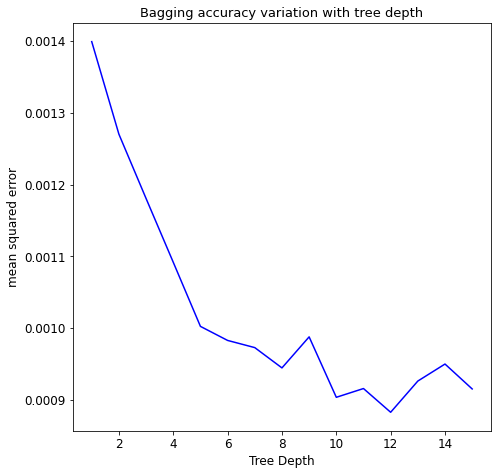

In [98]:
plt.subplots(figsize=(2.5*fig_scale, 2.5*fig_scale))
plt.plot(range(1, max_depth+1), bag_mses, color='b', linewidth=0.5*fig_scale)
plt.xlabel("Tree Depth", fontsize=text_size)
plt.ylabel("mean squared error", fontsize=text_size)
plt.title("Bagging accuracy variation with tree depth", fontsize=text_size+1)
plt.tick_params(axis='x', labelsize=text_size)
plt.tick_params(axis='y', labelsize=text_size)
plt.savefig('Project_images/bag_mse_depth.pdf', bbox_inches="tight")

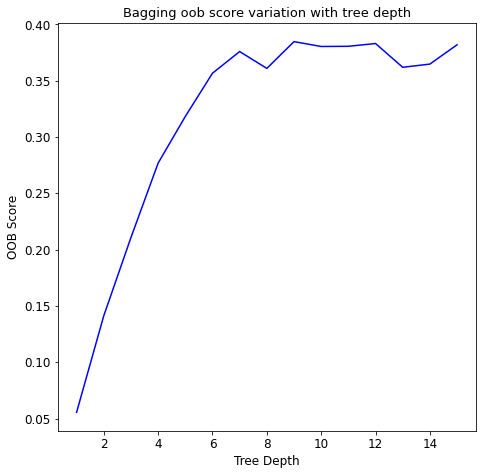

In [99]:
plt.subplots(figsize=(2.5*fig_scale, 2.5*fig_scale))
plt.plot(range(1, max_depth+1), bag_oob_scores, color='b', linewidth=0.5*fig_scale)
plt.xlabel("Tree Depth", fontsize=text_size)
plt.ylabel("OOB Score", fontsize=text_size)
plt.title("Bagging oob score variation with tree depth", fontsize=text_size+1)
plt.tick_params(axis='x', labelsize=text_size)
plt.tick_params(axis='y', labelsize=text_size)
plt.savefig('Project_images/bag_oob_depth.pdf', bbox_inches="tight")

In [100]:
max_bootstraps = 30
num_bootstraps = range(10, max_bootstraps+1)
max_depth = 10
bag_mses = []
bag_oob_scores = []
for n_bootstraps in num_bootstraps:
    model = BaggingRegressor(DecisionTreeRegressor(max_depth=max_depth),
                              n_estimators=n_bootstraps,
                              max_samples=0.8,
                              oob_score=True,
                              random_state=109)

    # Fit on the train data
    model.fit(X_train, y_train)

    # Predict on the test data
    y_pred_bag = model.predict(X_test)
    bag_mses.append(mean_squared_error(y_test, y_pred_bag))
    bag_oob_scores.append(model.oob_score_)

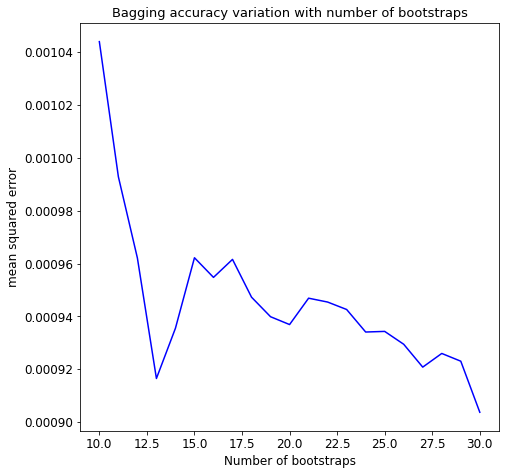

In [101]:
plt.subplots(figsize=(2.5*fig_scale, 2.5*fig_scale))
plt.plot(num_bootstraps, bag_mses, color='b', linewidth=0.5*fig_scale)
plt.xlabel("Number of bootstraps", fontsize=text_size)
plt.ylabel("mean squared error", fontsize=text_size)
plt.title("Bagging accuracy variation with number of bootstraps", fontsize=text_size+1)
plt.tick_params(axis='x', labelsize=text_size)
plt.tick_params(axis='y', labelsize=text_size)
plt.savefig('Project_images/bag_mse_nboots.pdf', bbox_inches="tight")

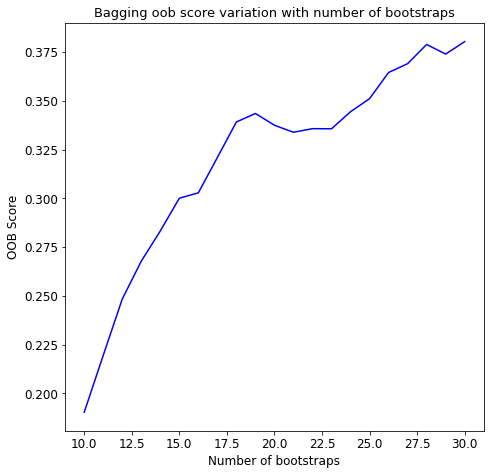

In [102]:
plt.subplots(figsize=(2.5*fig_scale, 2.5*fig_scale))
plt.plot(num_bootstraps, bag_oob_scores, color='b', linewidth=0.5*fig_scale)
plt.xlabel("Number of bootstraps", fontsize=text_size)
plt.ylabel("OOB Score", fontsize=text_size)
plt.title("Bagging oob score variation with number of bootstraps", fontsize=text_size+1)
plt.tick_params(axis='x', labelsize=text_size)
plt.tick_params(axis='y', labelsize=text_size)
plt.savefig('Project_images/bag_oob_nboots.pdf', bbox_inches="tight")

### Boosting

In [103]:
# Baseline boosting model

l_rate = 0.05
n_estimators = 30

# Initialise a Boosting model using sklearn's boosting model 
# Use 1000 estimators, depth of 1 and learning rate as defined above
boosted_model  = GradientBoostingRegressor(n_estimators=n_estimators,
                                        max_depth=1,
                                        learning_rate=l_rate)

# Fit on the train data
boosted_model.fit(X_train, y_train)

# Predict on the test data
y_pred_boost = boosted_model.predict(X_test)


In [104]:
print(f'Boosting error: {mean_squared_error(y_test, y_pred_boost):.3f}.')

Boosting error: 0.001.


In [86]:
l_rate = 0.05
n_estimators = 30

top_predictors_boost = pd.Series(index=data.drop('Sav_rate', axis=1).columns, dtype=int)
for j in range(10):
    model = GradientBoostingRegressor(n_estimators=n_estimators,
                                            max_depth=1,
                                            learning_rate=l_rate)
    model.fit(X_train, y_train)
    for i in range(n_estimators):
        top_predictors_boost[model.estimators_[i][0].tree_.feature[0]] += 1

top_predictors_boost /= 10
top_predictors_boost.loc[top_predictors_boost > 0].sort_values(ascending=False)

RegTrndUpdt                   5.0
RevLossLimit                  5.0
chf_adm                       5.0
N_AB_Year_DIS_BY3             3.0
MinSavPerc                    2.2
RecvdMean                     2.0
Adv_Pay                       1.8
ADM_Psych                     1.7
ADM_Rehab                     1.3
QualScore                     1.0
CMS_HCC_RiskScore_ESRD_BY2    1.0
CapAnn_OPD                    1.0
dtype: float64

In [105]:
max_estimators = 100
boost_mses = []
for i in range(10, max_estimators+1):
    model = GradientBoostingRegressor(n_estimators=i,
                                        max_depth=1,
                                        learning_rate=l_rate)

    # Fit on the train data
    model.fit(X_train, y_train)

    # Predict on the test data
    y_pred_boost = model.predict(X_test)
    boost_mses.append(mean_squared_error(y_test, y_pred_boost))
    

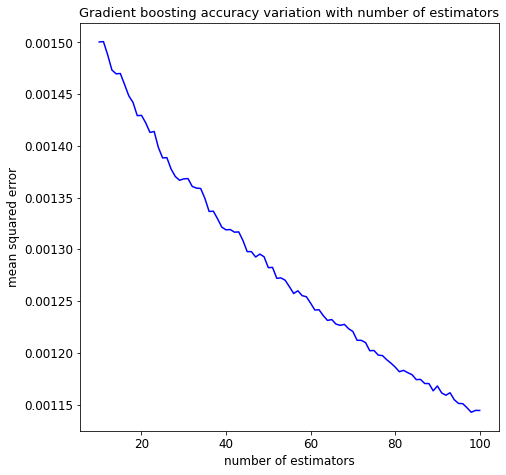

In [106]:
plt.subplots(figsize=(2.5*fig_scale, 2.5*fig_scale))
plt.plot(range(10, max_estimators+1), boost_mses, color='b', linewidth=0.5*fig_scale)
plt.xlabel("number of estimators", fontsize=text_size)
plt.ylabel("mean squared error", fontsize=text_size)
plt.title("Gradient boosting accuracy variation with number of estimators", fontsize=text_size+1)
plt.tick_params(axis='x', labelsize=text_size)
plt.tick_params(axis='y', labelsize=text_size)
plt.savefig('Project_images/gb_mse_nestm.pdf', bbox_inches="tight")

In [107]:
max_lrate = 0.3
lrates = np.linspace(0.01, max_lrate, 300)
boost_mses = []
for lrate in lrates:
    model = GradientBoostingRegressor(n_estimators=100,
                                        max_depth=1,
                                        learning_rate=lrate)

    # Fit on the train data
    model.fit(X_train, y_train)

    # Predict on the test data
    y_pred_boost = model.predict(X_test)
    boost_mses.append(mean_squared_error(y_test, y_pred_boost))

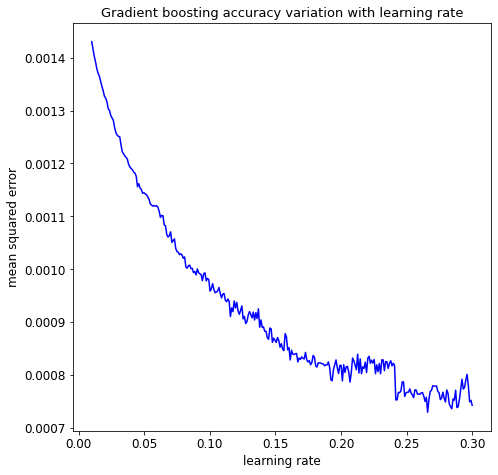

In [108]:
plt.subplots(figsize=(2.5*fig_scale, 2.5*fig_scale))
plt.plot(lrates, boost_mses, color='b', linewidth=0.5*fig_scale)
plt.xlabel("learning rate", fontsize=text_size)
plt.ylabel("mean squared error", fontsize=text_size)
plt.title("Gradient boosting accuracy variation with learning rate", fontsize=text_size+1)
plt.tick_params(axis='x', labelsize=text_size)
plt.tick_params(axis='y', labelsize=text_size)
plt.savefig('Project_images/gb_mse_lrate.pdf', bbox_inches="tight")

## KNN

### KNN model 

In [236]:
k_value_min = 1
k_value_max = 100

k_list = np.linspace(k_value_min,k_value_max,num=100,dtype=int)

cross_validation_error = []
cross_validation_std = []
train_score_list = []

for k_value in k_list:
    knn_model = KNeighborsRegressor(n_neighbors=k_value)
    knn_model.fit(X_train, y_train)
    accu = cross_validate(knn_model, X_train, y_train, scoring = 'r2', cv=10)['test_score'].mean()
    std = cross_validate(knn_model, X_train, y_train, scoring = 'r2', cv=10)['test_score'].std()
    train_score = knn_model.score(X_train, y_train)
    cross_validation_error.append(accu)
    cross_validation_std.append(std)
    train_score_list.append(train_score)


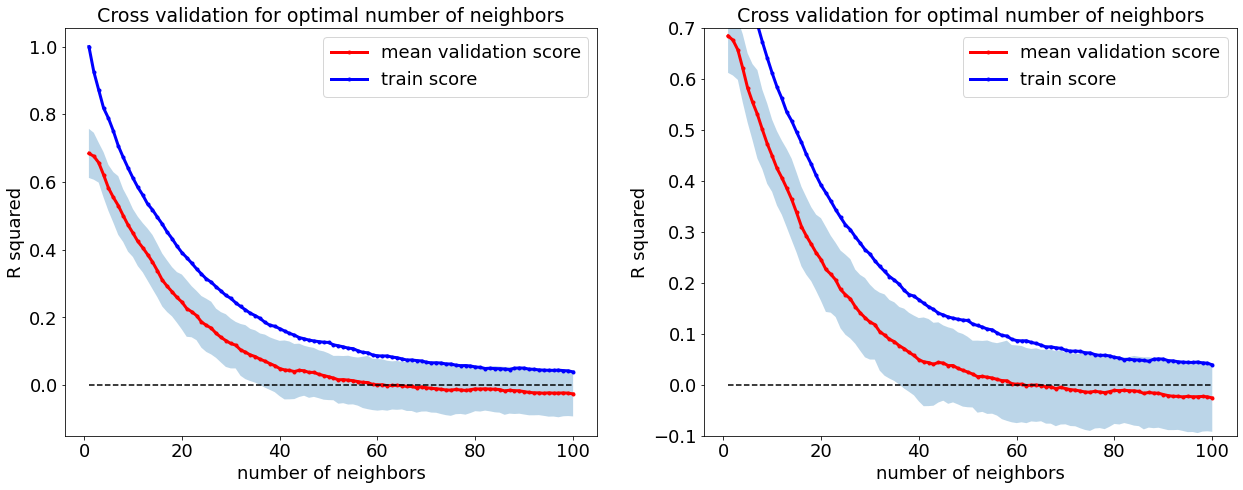

In [237]:
fig, ax = plt.subplots(1,2, figsize=(7*fig_scale, 2.5*fig_scale))
ax[0].plot(k_list, cross_validation_error, 'ro-', label='mean validation score', linewidth=1*fig_scale, markersize=1*fig_scale)
ax[0].plot(k_list, train_score_list, 'bo-', label='train score', linewidth=1*fig_scale, markersize=1*fig_scale)
ax[0].fill_between(k_list, np.array(cross_validation_error)+np.array(cross_validation_std), np.array(cross_validation_error)-np.array(cross_validation_std), alpha=0.3)
ax[0].plot(k_list, np.zeros(len(k_list)), 'k--')
ax[0].set_xlabel('number of neighbors', fontsize=text_size)
ax[0].set_ylabel('R squared', fontsize=text_size)
ax[0].set_title('Cross validation for optimal number of neighbors', fontsize=text_size+1)
ax[0].tick_params(axis='x', labelsize=text_size)
ax[0].tick_params(axis='y', labelsize=text_size)
ax[0].legend(fontsize=text_size)

ax[1].plot(k_list, cross_validation_error, 'ro-', label='mean validation score', linewidth=1*fig_scale, markersize=1*fig_scale)
ax[1].plot(k_list, train_score_list, 'bo-', label='train score', linewidth=1*fig_scale, markersize=1*fig_scale)
ax[1].fill_between(k_list, np.array(cross_validation_error)+np.array(cross_validation_std), np.array(cross_validation_error)-np.array(cross_validation_std), alpha=0.3)
ax[1].plot(k_list, np.zeros(len(k_list)), 'k--')
ax[1].set_xlabel('number of neighbors', fontsize=text_size)
ax[1].set_ylabel('R squared', fontsize=text_size)
ax[1].set_title('Cross validation for optimal number of neighbors', fontsize=text_size+1)
ax[1].set_ylim(-0.1, 0.7)
ax[1].tick_params(axis='x', labelsize=text_size)
ax[1].tick_params(axis='y', labelsize=text_size)
ax[1].legend(fontsize=text_size)
#plt.savefig('Project_images/cv_kvalues.pdf', bbox_inches="tight")

figure.tight_layout()

### Lasso cross-validation using KNN model

In [223]:
reg = LassoCV(max_iter=10000)
reg.fit(X_train_scaled, y_train)
coef = pd.Series(reg.coef_, index = X_train.columns)

imp_coef = coef.sort_values()
X_train_lasso = X_train[imp_coef[abs(imp_coef)>1e-3].index]
X_test_lasso = X_test[imp_coef[abs(imp_coef)>1e-3].index]

k_value_min = 1
k_value_max = 100

k_list = np.linspace(k_value_min,k_value_max,num=100,dtype=int)

cross_validation_error = []
cross_validation_std = []
train_score_list = []

for k_value in k_list:
    knn_model = KNeighborsRegressor(n_neighbors=k_value)
    knn_model.fit(X_train_lasso, y_train)
    accu = cross_validate(knn_model, X_train_lasso, y_train, scoring = 'r2', cv=10)['test_score'].mean()
    std = cross_validate(knn_model, X_train_lasso, y_train, scoring = 'r2', cv=10)['test_score'].std()
    train_score = knn_model.score(X_train_lasso, y_train)
    cross_validation_error.append(accu)
    cross_validation_std.append(std)
    train_score_list.append(train_score)

In [216]:
len(imp_coef[abs(imp_coef)>1e-3])

49

In [217]:
imp_coef[abs(imp_coef)>1e-3]

Per_Capita_Exp_TOTAL_PY       -0.199
N_AB_Year_AGED_Dual_BY3       -0.028
Per_Capita_Exp_ALL_AGND_BY3   -0.012
N_AB_Year_DIS_PY              -0.009
N_Ben_Age_75_84               -0.005
CapAnn_PB                     -0.005
Per_Capita_Exp_ALL_AGND_BY1   -0.005
ABtotExp                      -0.005
HistBnchmk                    -0.004
Per_Capita_Exp_ALL_AGDU_PY    -0.004
CapAnn_HSP                    -0.003
CapAnn_INP_S_trm              -0.003
Per_Capita_Exp_ALL_AGND_BY2   -0.003
CapAnn_OPD                    -0.002
CapAnn_INP_L_trm              -0.002
CMS_HCC_RiskScore_DIS_BY2     -0.002
CMS_HCC_RiskScore_AGDU_BY3    -0.002
CapAnn_HHA                    -0.002
CMS_HCC_RiskScore_ESRD_BY3    -0.002
prov_Rate_1000                -0.002
Per_Capita_Exp_ALL_ESRD_BY1   -0.002
Rev_Exp_Cat_High Revenue      -0.002
ADM_S_Trm                     -0.002
P_EDV_Vis                     -0.001
P_FQHC_RHC_Vis                -0.001
CMS_HCC_RiskScore_AGND_BY3    -0.001
CMS_HCC_RiskScore_ESRD_BY2     0.001
N

Text(0.5, 0.98, 'Cross validation for optimal number of neighbors after LASSO regularization')

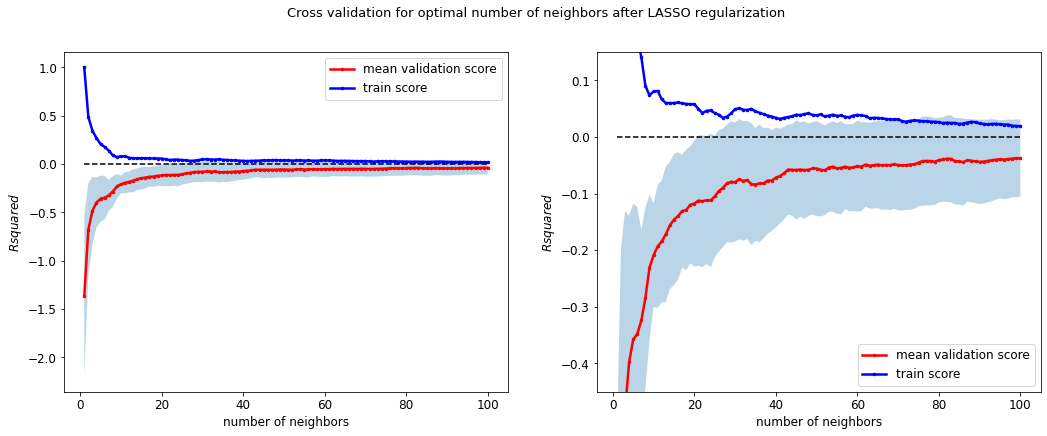

In [224]:
fig, ax = plt.subplots(1,2, figsize=(7*fig_scale, 2.5*fig_scale))
ax[0].plot(k_list, cross_validation_error, 'ro-', label='mean validation score', linewidth=1*fig_scale, markersize=1*fig_scale)
ax[0].plot(k_list, train_score_list, 'bo-', label='train score', linewidth=1*fig_scale, markersize=1*fig_scale)
ax[0].fill_between(k_list, np.array(cross_validation_error)+np.array(cross_validation_std), np.array(cross_validation_error)-np.array(cross_validation_std), alpha=0.3)
ax[0].plot(k_list, np.zeros(len(k_list)), 'k--')
ax[0].set_xlabel('number of neighbors', fontsize=text_size)
ax[0].set_ylabel('$R squared$', fontsize=text_size)
ax[0].tick_params(axis='x', labelsize=text_size)
ax[0].tick_params(axis='y', labelsize=text_size)
#ax[0].set_title('Cross validation for optimal number of neighbors')
ax[0].legend(fontsize=text_size)

ax[1].plot(k_list, cross_validation_error, 'ro-', label='mean validation score', linewidth=1*fig_scale, markersize=1*fig_scale)
ax[1].plot(k_list, train_score_list, 'bo-', label='train score', linewidth=1*fig_scale, markersize=1*fig_scale)
ax[1].fill_between(k_list, np.array(cross_validation_error)+np.array(cross_validation_std), np.array(cross_validation_error)-np.array(cross_validation_std), alpha=0.3)
ax[1].plot(k_list, np.zeros(len(k_list)), 'k--')
ax[1].set_xlabel('number of neighbors', fontsize=text_size)
ax[1].set_ylabel('R squared', fontsize=text_size)
ax[1].tick_params(axis='x', labelsize=text_size)
ax[1].tick_params(axis='y', labelsize=text_size)
#ax[1].set_title('Cross validation for optimal number of neighbors')
ax[1].set_ylim(-0.45, 0.15)
ax[1].legend(loc='lower right', fontsize=text_size)
plt.suptitle('Cross validation for optimal number of neighbors after LASSO regularization', fontsize=text_size+1)
#plt.savefig('Project_images/cv_kvalues_reducedim.pdf', bbox_inches="tight")

In [176]:
k_list[cross_validation_error.index(max(cross_validation_error))]

99

In [177]:
max(cross_validation_error)

-0.03747465969485222

In [180]:
knn_model = KNeighborsRegressor(n_neighbors=99)
knn_model.fit(X_train_lasso, y_train)
perm = PermutationImportance(knn_model, random_state=32, n_iter=15).fit(X_test_lasso, y_test)
train_accuracy = knn_model.score(X_train_lasso, y_train)
test_accuracy = knn_model.score(X_test_lasso, y_test)
print('The train accuracy using the best parameters is ', train_accuracy)
print('The test accuracy using the best parameters is ', test_accuracy)
eli5.show_weights(perm, feature_names=X_test_lasso.columns.tolist(), top = 40)

The train accuracy using the best parameters is  0.019374112622334683
The test accuracy using the best parameters is  -0.04035317647441694


Text(0.5, 1.0, 'Permutation feature importance')

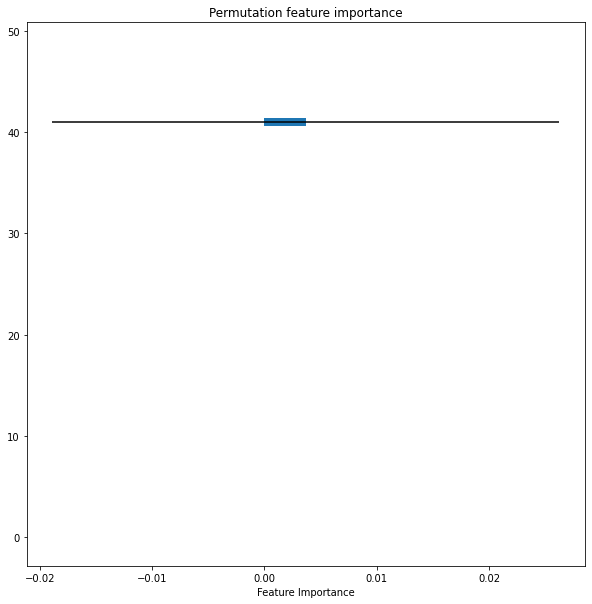

In [181]:
importance = perm.feature_importances_
std = perm.feature_importances_std_
figure, ax = plt.subplots(figsize=(10,10))
num_features = len(importance)
ax.barh(np.flip(np.arange(num_features)), importance, align='center', xerr=std)
ax.set_xlabel('Feature Importance')
ax.set_title('Permutation feature importance')
# ax.tick_params(axis='x', labelsize=5)
# ax.tick_params(axis='y', labelsize=5)

In [190]:
knn_model = KNeighborsRegressor(n_neighbors=1)
knn_model.fit(X_train, y_train)
perm = PermutationImportance(knn_model, random_state=32, n_iter=15).fit(X_test, y_test)
eli5.show_weights(perm, feature_names=X_test.columns.tolist())

In [189]:
model = KNeighborsRegressor(n_neighbors=1)
model.fit(X_train, y_train)
train_accuracy = model.score(X_train, y_train)
test_accuracy = model.score(X_test, y_test)
print('The train accuracy using the best parameters is ', train_accuracy)
print('The test accuracy using the best parameters is ', test_accuracy)

The train accuracy using the best parameters is  1.0
The test accuracy using the best parameters is  0.7671867429482725


In [188]:
model = KNeighborsRegressor(n_neighbors=1)
model.fit(X_train_scaled, y_train)
train_accuracy = model.score(X_train_scaled, y_train)
test_accuracy = model.score(X_test_scaled, y_test)
print('The train accuracy using the best parameters is ', train_accuracy)
print('The test accuracy using the best parameters is ', test_accuracy)

The train accuracy using the best parameters is  1.0
The test accuracy using the best parameters is  -0.4638906512443193


## Linear Regression

### Baseline Linear Regression

In [109]:
X_train_sm = sm.add_constant(X_train, prepend=True, has_constant='add')
model = sm.OLS(y_train, X_train_sm)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Sav_rate   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     131.1
Date:                Thu, 09 Dec 2021   Prob (F-statistic):          1.06e-203
Time:                        13:01:31   Log-Likelihood:                 1473.1
No. Observations:                 410   AIC:                            -2720.
Df Residuals:                     297   BIC:                            -2266.
Df Model:                         112                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                           0.0237      0.023      1.010      0.313      -0.023       0.070
Agreement_Period_Num            0.0001      0.001      0.091      0.928      -0.002       0.002
AIM                             0.0043      0.003      1.615      0.107      -0.001       0.009
SNF_Waiver                      0.0006      0.002      0.349      0.728      -0.003       0.004
N_AB                            0.0007      0.005      0.153      0.878      -0.009       0.010
MinSavPerc                     -0.0518      0.070     -0.742      0.458      -0.189       0.086
DisAffQual                      0.0237      0.023      1.010      0.313      -0.023       0.070
Met_QPS                         0.0237      0.023      1.010      0.313      -0.023       0.070
QualScore                      -0.0005      0.001     -0.532      0.595      -0.002       0.001
RecvdMean                       0.0001      0.001      0.107      0.915      -0.002       0.003
RegTrndUpdt                    -0.0002      0.002     -0.091      0.928      -0.004       0.004
UpdatedBnchmk                8.521e-05   2.16e-06     39.451      0.000     8.1e-05    8.95e-05
HistBnchmk                    4.16e-07   2.32e-06      0.179      0.858   -4.15e-06    4.98e-06
ABtotBnchmk                  2.754e-10   9.18e-11      2.999      0.003    9.47e-11    4.56e-10
ABtotExp                    -2.923e-10      9e-11     -3.249      0.001   -4.69e-10   -1.15e-10
QualPerfShare                  -0.2039      0.144     -1.417      0.157      -0.487       0.079
FinalShareRate                  0.1982      0.146      1.355      0.176      -0.090       0.486
Per_Capita_Exp_ALL_ESRD_BY1 -1.611e-07   7.15e-08     -2.254      0.025   -3.02e-07   -2.04e-08
Per_Capita_Exp_ALL_DIS_BY1   1.359e-06   7.99e-07      1.700      0.090   -2.14e-07    2.93e-06
Per_Capita_Exp_ALL_AGDU_BY1  3.167e-07   4.04e-07      0.784      0.434   -4.78e-07    1.11e-06
Per_Capita_Exp_ALL_AGND_BY1 -3.252e-06   1.62e-06     -2.002      0.046   -6.45e-06   -5.51e-08
Per_Capita_Exp_ALL_ESRD_BY2  1.186e-07      7e-08      1.695      0.091   -1.91e-08    2.56e-07
Per_Capita_Exp_ALL_DIS_BY2   -6.08e-07   8.51e-07     -0.714      0.476   -2.28e-06    1.07e-06
Per_Capita_Exp_ALL_AGDU_BY2 -1.655e-07   4.12e-07     -0.401      0.688   -9.77e-07    6.46e-07
Per_Capita_Exp_ALL_AGND_BY2 -1.438e-06   1.75e-06     -0.820      0.413   -4.89e-06    2.01e-06
Per_Capita_Exp_ALL_ESRD_BY3 -4.675e-08   6.11e-08     -0.766      0.445   -1.67e-07    7.34e-08
Per_Capita_Exp_ALL_DIS_BY3   2.019e-06   7.61e-07      2.652      0.008     5.2e-07    3.52e-06
Per_Capita_Exp_ALL_AGDU_BY3  5.815e-07   3.94e-07      1.476      0.141   -1.94e-07    1.36e-06
Per_Capita_Exp_ALL_AGND_BY3 -5.976e-06   1.67e-06     -3.585      0.000   -9.26e-06    -2.7e-06
Per_Capita_

In [110]:
#Print Coefficients with Significant P value

pvals = results.pvalues
coefs = results.params


results_df = pd.DataFrame({"coef": coefs, "P-value":pvals})
sig_coefs = results_df[results_df["P-value"] <= .05]
sig_coefs.sort_values(by = ['P-value'], inplace=True, axis=0)
sig_coefs.to_csv("Results/significant_coefs.csv")
sig_coefs

<ipython-input-110-77fa2a90c1c0>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sig_coefs.sort_values(by = ['P-value'], inplace=True, axis=0)


coef     P-value
UpdatedBnchmk                8.521e-05  4.112e-120
Per_Capita_Exp_TOTAL_PY     -8.990e-05   3.599e-33
N_AB_Year_AGED_Dual_BY3     -2.211e-05   9.869e-14
Per_Capita_Exp_ALL_AGND_PY   1.085e-05   4.078e-06
N_AB_Year_DIS_BY3            8.178e-06   3.108e-04
Per_Capita_Exp_ALL_AGND_BY3 -5.976e-06   3.934e-04
ABtotExp                    -2.923e-10   1.290e-03
ABtotBnchmk                  2.754e-10   2.934e-03
CapAnn_AmbPay                3.928e-05   3.780e-03
Per_Capita_Exp_ALL_DIS_BY3   2.019e-06   8.442e-03
Per_Capita_Exp_ALL_AGDU_PY  -8.240e-07   9.167e-03
CMS_HCC_RiskScore_ESRD_BY3  -2.982e-02   1.744e-02
CapAnn_SNF                   1.512e-05   2.051e-02
CapAnn_INP_L_trm            -7.017e-05   2.086e-02
Per_Capita_Exp_ALL_ESRD_BY1 -1.611e-07   2.493e-02
N_AB_Year_AGED_NonDual_BY3   5.470e-07   3.609e-02
Per_Capita_Exp_ALL_AGND_BY1 -3.252e-06   4.621e-02

In [111]:
#Linear Regression with Cross Validation

lr = LinearRegression()

results = cross_validate(lr, X_train, y_train, cv=10, scoring = 'neg_mean_squared_error', return_train_score=True)
train_mse_lr = np.mean(-1*results['train_score'])
val_mse_lr = np.mean(-1*results['test_score'])
val_mse_stds_lr = np.std(-1*results['test_score'])
    
print(f"Mean training set MSE: {train_mse_lr:.7f}. Mean validation set MSE: {val_mse_lr:.7f} ")


#Overall Fitted Model
lr.fit(X_train, y_train)
train_mse_lr_full = mean_squared_error(lr.predict(X_train), y_train)
r2_train_lr_full = r2_score(lr.predict(X_train), y_train)

test_mse_lr_full = mean_squared_error(lr.predict(X_test), y_test)
r2_test_lr_full = r2_score(lr.predict(X_test), y_test)

print(f"Overall training set MSE: {train_mse_lr_full:.7f}. Overall test set MSE: {test_mse_lr_full:.7f} ")
print(f"Overall training set R2: {r2_train_lr_full:.3f}. Overall test set R2: {r2_test_lr_full:.3f} ")

Mean training set MSE: 0.0000408. Mean validation set MSE: 0.0003137 
Overall training set MSE: 0.0000443. Overall test set MSE: 0.0001732 
Overall training set R2: 0.980. Overall test set R2: 0.904 


### Residual Plot

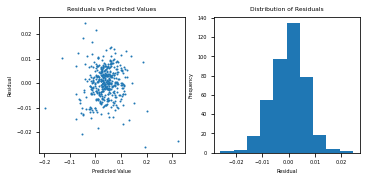

In [118]:
yhat = lr.predict(X_train)

figure, axs = plt.subplots(1,2, figsize=(5.75*fig_scale,2.5*fig_scale))
axs = axs.ravel()

resid = y_train - yhat
axs[0].scatter(yhat, resid, s=1*fig_scale)
axs[0].set_xlabel("Predicted Value", fontsize=text_size)
axs[0].set_ylabel("Residual", fontsize=text_size)
axs[0].set_title("Residuals vs Predicted Values", fontsize=text_size+1)
axs[0].tick_params(axis='x', labelsize=text_size)
axs[0].tick_params(axis='y', labelsize=text_size)

axs[1].hist(resid)
axs[1].set_xlabel("Residual", fontsize=text_size)
axs[1].set_ylabel("Frequency", fontsize=text_size)
axs[1].set_title("Distribution of Residuals", fontsize=text_size+1)
axs[1].tick_params(axis='x', labelsize=text_size)
axs[1].tick_params(axis='y', labelsize=text_size)
plt.savefig('Project_images/regression_residuals.pdf', bbox_inches="tight")
plt.show()



### Lasso Linear Regression

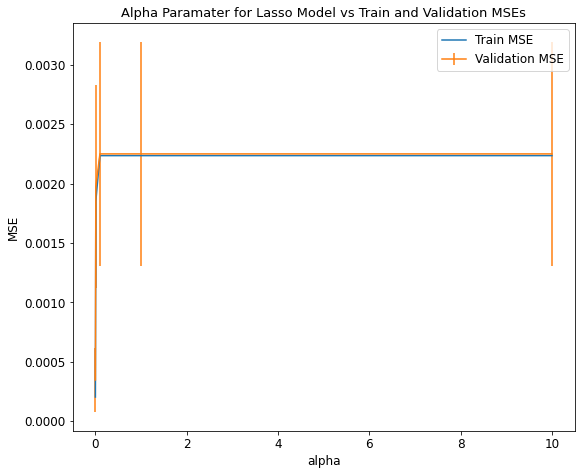

Alpha of Best Model: 0.001. Mean training set MSE: 0.0002040. Mean validation set MSE: 0.0003477 
Overall training set MSE: 0.0000545. Overall test set MSE: 0.0001798 
Overall training set R2: 0.975. Overall test set R2: 0.897 


In [240]:
%%capture --no-stdout --no-display

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# your code here
train_MSEs = []
val_MSEs = []
val_MSEs_stds = []

alphas = [1e-3, 1e-2, 1e-1, 1e0, 1e1]

for alpha in alphas:    
    # Initialize a Lasso Linear Regression object
    lasso = Lasso(alpha = alpha, max_iter=10000)
    
    results = cross_validate(lasso, X_train_scaled, y_train, cv=10, scoring = 'neg_mean_squared_error', return_train_score=True)
    train_MSEs.append(np.mean(-1*results['train_score']))
    val_MSEs.append(np.mean(-1*results['test_score']))
    val_MSEs_stds.append(np.std(-1*results['test_score']))

plt.subplots(figsize=(3*fig_scale, 2.5*fig_scale))
plt.plot(alphas, train_MSEs, label="Train MSE")
plt.errorbar(alphas, val_MSEs, label="Validation MSE", yerr=val_MSEs_stds)
plt.xlabel("alpha", fontsize=text_size)
plt.ylabel("MSE", fontsize=text_size)
plt.legend(fontsize=text_size)
plt.title("Alpha Paramater for Lasso Model vs Train and Validation MSEs", fontsize=text_size+1)
plt.tick_params(axis='x', labelsize=text_size)
plt.tick_params(axis='y', labelsize=text_size)
#plt.savefig('Project_images/lasso_tuning.pdf', bbox_inches="tight")
plt.show()

best_alpha_lasso = alphas[val_MSEs.index(min(val_MSEs))]
train_mse_lasso = train_MSEs[val_MSEs.index(min(val_MSEs))]
val_mse_lasso = min(val_MSEs)


print(f"Alpha of Best Model: {best_alpha_lasso}. Mean training set MSE: {train_mse_lasso:.7f}. Mean validation set MSE: {val_mse_lasso:.7f} ")


#Overall Fitted Model
lasso = Lasso(alpha = best_alpha_lasso, max_iter=10000)
lasso.fit(X_train, y_train)
train_mse_lasso_full = mean_squared_error(lasso.predict(X_train), y_train)
r2_train_lasso_full = r2_score(lasso.predict(X_train), y_train)

test_mse_lasso_full = mean_squared_error(lasso.predict(X_test), y_test)
r2_test_lasso_full = r2_score(lasso.predict(X_test), y_test)

print(f"Overall training set MSE: {train_mse_lasso_full:.7f}. Overall test set MSE: {test_mse_lasso_full:.7f} ")
print(f"Overall training set R2: {r2_train_lasso_full:.3f}. Overall test set R2: {r2_test_lasso_full:.3f} ")


In [124]:
#Print significant coefficients


results_df = pd.DataFrame({"Variable": X_train.columns, "Coef":lasso.coef_})
sig_coefs = results_df[np.abs(results_df["Coef"]) > 1e-5]

#here we can roughly sort by the absolute value of coefficient value due to standardization
sig_coefs["Abs Coef"] = [np.abs(x) for x in sig_coefs["Coef"]]
sig_coefs.sort_values(by = ['Abs Coef'], inplace=True, ascending=False, axis=0)
sig_coefs.drop(['Abs Coef'], axis=1, inplace=True)
sig_coefs.to_csv("Results/lasso_coefs.csv")

sig_coefs

<ipython-input-124-cebe5e6801dd>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sig_coefs["Abs Coef"] = [np.abs(x) for x in sig_coefs["Coef"]]
<ipython-input-124-cebe5e6801dd>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sig_coefs.sort_values(by = ['Abs Coef'], inplace=True, ascending=False, axis=0)
D:\Users\aaron\Anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

Variable       Coef
102                    N_RHC  1.325e-04
32   Per_Capita_Exp_TOTAL_PY -8.839e-05
10             UpdatedBnchmk  8.428e-05
101                   N_FQHC  5.911e-05
99                 P_SNF_ADM  5.381e-05
54         N_AB_Year_ESRD_PY  5.264e-05
49        N_AB_Year_ESRD_BY3 -5.242e-05
91            P_EDV_Vis_HOSP  3.604e-05
83                 ADM_S_Trm -3.407e-05
79             CapAnn_AmbPay  2.782e-05
74          CapAnn_INP_Psych -2.488e-05
51   N_AB_Year_AGED_Dual_BY3 -2.485e-05
56    N_AB_Year_AGED_Dual_PY  2.269e-05
71          CapAnn_INP_S_trm -1.864e-05
89            prov_Rate_1000 -1.782e-05
93                 P_MRI_VIS  1.493e-05
70            CapAnn_INP_All  1.199e-05
55          N_AB_Year_DIS_PY -1.115e-05
109                     N_PA  1.103e-05
50         N_AB_Year_DIS_BY3  1.050e-05

### Ridge Regression

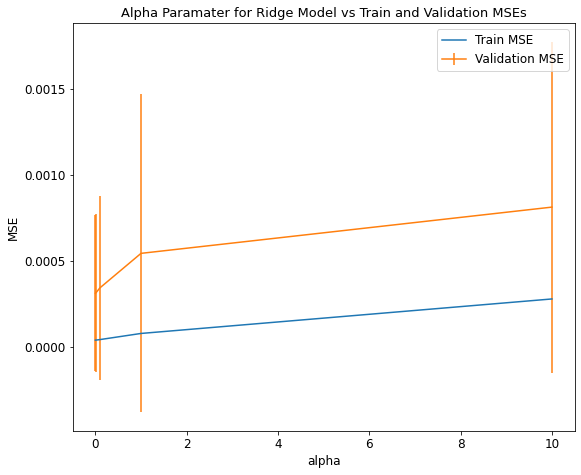

Alpha of Best Model: 0.001. Mean training set MSE: 0.0000415. Mean validation set MSE: 0.0003133 
Overall training set MSE: 0.0000444. Overall test set MSE: 0.0001727 
Overall training set R2: 0.980. Overall test set R2: 0.904 


In [239]:
%%capture --no-stdout --no-display

# your code here
train_MSEs = []
val_MSEs = []
val_MSEs_stds = []

alphas = [1e-3, 1e-2, 1e-1, 1e0, 1e1]

for alpha in alphas:    
    # Initialize a Ridge Linear Regression object
    ridge = Ridge(alpha = alpha, max_iter=10000)
    
    results = cross_validate(ridge, X_train_scaled, y_train, cv=10, scoring = 'neg_mean_squared_error', return_train_score=True)
    train_MSEs.append(np.mean(-1*results['train_score']))
    val_MSEs.append(np.mean(-1*results['test_score']))
    val_MSEs_stds.append(np.std(-1*results['test_score']))

plt.subplots(figsize=(3*fig_scale, 2.5*fig_scale))
plt.plot(alphas, train_MSEs, label="Train MSE")
plt.errorbar(alphas, val_MSEs, label="Validation MSE", yerr=val_MSEs_stds)
plt.xlabel("alpha", fontsize=text_size)
plt.ylabel("MSE", fontsize=text_size)
plt.legend(fontsize=text_size)
plt.title("Alpha Paramater for Ridge Model vs Train and Validation MSEs", fontsize=text_size+1)
plt.tick_params(axis='x', labelsize=text_size)
plt.tick_params(axis='y', labelsize=text_size)
#plt.savefig('Project_images/ridge_tuning.pdf', bbox_inches="tight")
plt.show()

best_alpha_ridge = alphas[val_MSEs.index(min(val_MSEs))]
train_mse_ridge = train_MSEs[val_MSEs.index(min(val_MSEs))]
val_mse_ridge = min(val_MSEs)


print(f"Alpha of Best Model: {best_alpha_ridge}. Mean training set MSE: {train_mse_ridge:.7f}. Mean validation set MSE: {val_mse_ridge:.7f} ")

#Overall Fitted Model
ridge = Ridge(alpha = best_alpha_ridge, max_iter=10000)
ridge.fit(X_train, y_train)
train_mse_ridge_full = mean_squared_error(ridge.predict(X_train), y_train)
r2_train_ridge_full = r2_score(ridge.predict(X_train), y_train)

test_mse_ridge_full = mean_squared_error(ridge.predict(X_test), y_test)
r2_test_ridge_full = r2_score(ridge.predict(X_test), y_test)

print(f"Overall training set MSE: {train_mse_ridge_full:.7f}. Overall test set MSE: {test_mse_ridge_full:.7f} ")
print(f"Overall training set R2: {r2_train_ridge_full:.3f}. Overall test set R2: {r2_test_ridge_full:.3f} ")




In [130]:
#Print significant coefficients

results_df = pd.DataFrame({"Variable": X_train.columns, "Coef":ridge.coef_})
sig_coefs = results_df[np.abs(results_df["Coef"]) > 1e-2]

#here we can roughly sort by the absolute value of coefficient value due to standardization
sig_coefs["Abs Coef"] = [np.abs(x) for x in sig_coefs["Coef"]]
sig_coefs.sort_values(by = ['Abs Coef'], inplace=True, ascending=False, axis=0)
sig_coefs.drop(['Abs Coef'], axis=1, inplace=True)
sig_coefs.to_csv("Results/ridge_coefs.csv")

sig_coefs

<ipython-input-130-d992f1e76de0>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sig_coefs["Abs Coef"] = [np.abs(x) for x in sig_coefs["Coef"]]
<ipython-input-130-d992f1e76de0>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sig_coefs.sort_values(by = ['Abs Coef'], inplace=True, ascending=False, axis=0)
D:\Users\aaron\Anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

Variable   Coef
14               QualPerfShare -0.123
15              FinalShareRate  0.116
4                   MinSavPerc -0.048
36  CMS_HCC_RiskScore_AGND_BY1  0.036
41  CMS_HCC_RiskScore_ESRD_BY3 -0.030
40  CMS_HCC_RiskScore_AGND_BY2  0.030
43  CMS_HCC_RiskScore_AGDU_BY3 -0.024
33  CMS_HCC_RiskScore_ESRD_BY1  0.023
37  CMS_HCC_RiskScore_ESRD_BY2  0.023
44  CMS_HCC_RiskScore_AGND_BY3 -0.020
38   CMS_HCC_RiskScore_DIS_BY2 -0.017
46    CMS_HCC_RiskScore_DIS_PY  0.015
48   CMS_HCC_RiskScore_AGND_PY -0.012

### Linear Model summary

In [148]:
lm_df = pd.DataFrame({"Model":["Linear Regression", "PCA-Transformed Linear Regression", "Lasso Regression", "Ridge Regression"],
         "Mean Training MSE": [train_mse_lr, train_mse_lr_pca, train_mse_lasso, train_mse_ridge ],
         "Mean Validation MSE": [val_mse_lr, val_mse_lr_pca, val_mse_lasso, val_mse_ridge],
         "Training Set MSE":[train_mse_lr_full, train_mse_lr_pca_full, train_mse_lasso_full, train_mse_ridge_full],
         "Test Set MSE":[test_mse_lr_full, test_mse_lr_pca_full, test_mse_lasso_full, test_mse_ridge_full],   
         "Train Set R2":[r2_train_lr_full, r2_train_lr_pca_full, r2_train_lasso_full, r2_train_ridge_full], 
         "Test Set R2":[r2_test_lr_full, r2_test_lr_pca_full, r2_test_lasso_full, r2_test_ridge_full], 
        })
lm_df.set_index("Model", inplace=True)
lm_df.to_csv("Results/linear_model_summary.csv")
lm_df

Mean Training MSE  Mean Validation MSE  \
Model                                                                       
Linear Regression                          4.083e-05            3.137e-04   
PCA-Transformed Linear Regression          1.090e-03            1.580e-03   
Lasso Regression                           2.040e-04            3.477e-04   
Ridge Regression                           4.150e-05            3.133e-04   

                                   Training Set MSE  Test Set MSE  \
Model                                                               
Linear Regression                         4.435e-05     1.732e-04   
PCA-Transformed Linear Regression         1.104e-03     8.965e-04   
Lasso Regression                          5.449e-05     1.798e-04   
Ridge Regression                          4.439e-05     1.727e-04   

                                   Train Set R2  Test Set R2  
Model                                                         
Linear Regression                         0.980        0.904  
PCA-Transformed Linear Regression         0.026       -0.089  
Lasso Regression                          0.975        0.897  
Ridge Regression                          0.980        0.904

In [149]:
print("Significant Coefficients from Linear Regression (ranked by p-value)")

sig_coefs

Significant Coefficients from Linear Regression (ranked by p-value)


Variable   Coef
14               QualPerfShare -0.123
15              FinalShareRate  0.116
4                   MinSavPerc -0.048
36  CMS_HCC_RiskScore_AGND_BY1  0.036
41  CMS_HCC_RiskScore_ESRD_BY3 -0.030
40  CMS_HCC_RiskScore_AGND_BY2  0.030
43  CMS_HCC_RiskScore_AGDU_BY3 -0.024
33  CMS_HCC_RiskScore_ESRD_BY1  0.023
37  CMS_HCC_RiskScore_ESRD_BY2  0.023
44  CMS_HCC_RiskScore_AGND_BY3 -0.020
38   CMS_HCC_RiskScore_DIS_BY2 -0.017
46    CMS_HCC_RiskScore_DIS_PY  0.015
48   CMS_HCC_RiskScore_AGND_PY -0.012

References:

https://www.cms.gov/files/document/2021-shared-savings-program-fast-facts.pdf

https://www.milliman.com/en/insight/what-predictive-analytics-can-tell-us-about-key-drivers-of-mssp-results-2021-update

https://www.milliman.com/en/insight/-/media/Milliman/PDFs/2021-Articles/8-5-21-Appendix_1_-_predictive-analytics.ashx

https://data.cms.gov/medicare-shared-savings-program/performance-year-financial-and-quality-results

https://www.healthaffairs.org/do/10.1377/hblog20211008.785640/full/

https://www.cms.gov/Medicare/Medicare-Fee-for-Service-Payment/sharedsavingsprogram/Downloads/ssp-aco-participation-options.pdf

https://www.cms.gov/Medicare/Medicare-Fee-for-Service-Payment/sharedsavingsprogram/Downloads/Shared-Savings-Losses-Assignment-Spec-V6.pdf

https://www.investopedia.com/insurance/why-do-healthcare-costs-keep-rising/